In [1]:
%pip install httpx
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install tables
%pip install xgboost
%pip install scikit-learn
%pip install onnxruntime
%pip install onnxmltools


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import math

import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.lines as mlines
from scipy.spatial import transform as scipy_transform


# Helpers

In [3]:
import os

import httpx


class Clickhouse:
    credentials = {
        "user": os.environ['CLICKHOUSE_USER'],
        "password": os.environ['CLICKHOUSE_PASSWORD'],
    }
    url = os.environ['CLICKHOUSE_URL']

    def __init__(self):
        self._httpx_client = httpx.Client()

    def post(
        self,
        query: str,
        headers: dict = None,
        content: bytes = None,
    ) -> str:
        response = self._httpx_client.post(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
            content=content,
        )
        return response.text

    def get(
        self,
        query: str,
        headers: dict = None,
    ) -> str:
        response = self._httpx_client.get(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
        )
        return response.text


# Load Data

In [4]:
df = None
try:
    df = pd.read_hdf('./data/dataset_gross_prod_fixed.h5')
except FileNotFoundError:
    pass


In [5]:
if df is None:
    ch = Clickhouse()
    pos_csv_str = ch.get('SELECT * FROM raw_data FORMAT CSV')
    print(pos_csv_str[:200])


In [6]:
if df is None:
    df = pd.read_csv(
        io.StringIO(pos_csv_str),
        names=[
            'game_result_id', 'game_id', 'patient_id', 'exercise_id', 'timestamp', 'src',
            'side', 'h_rssi', 'h_gain', 'g_rssi', 'g_gain', 'forearm_quat_x',
            'forearm_quat_y', 'forearm_quat_z', 'forearm_quat_w', 'forearm_lia_x',
            'forearm_lia_y', 'forearm_lia_z', 'forearm_grv_x', 'forearm_grv_y',
            'forearm_grv_z', 'forearm_tilt', 'shoulder_quat_x', 'shoulder_quat_y',
            'shoulder_quat_z', 'shoulder_quat_w', 'shoulder_lia_x',
            'shoulder_lia_y', 'shoulder_lia_z', 'shoulder_grv_x', 'shoulder_grv_y',
            'shoulder_grv_z', 'shoulder_tilt', 'position_type'
        ],
    )
    df.to_hdf('./data/dataset_gross_prod.h5', key='df', mode='w')


In [7]:
df['patient_id'].unique()


array([588, 377, 245, 231, 552, 618, 612, 614, 594], dtype=int64)

In [8]:
game_results_patient_1 = df[df['patient_id'] == 612]['game_result_id'].unique()
game_results_patient_1


array([13371, 13373, 13387, 13389, 13391, 13504, 13505, 13506, 13507,
       13622, 13624, 13625, 13627, 13724, 13725, 13726, 13727],
      dtype=int64)

In [9]:
game_results_patient_2 = df[df['patient_id'] == 614]['game_result_id'].unique()
game_results_patient_2


array([13393, 13394, 13395, 13396, 13397, 13513, 13514, 13515, 13630,
       13631, 13632, 13633, 13733, 13734, 13735, 13736], dtype=int64)

# Discover data

In [10]:
df.head(5)


,game_result_id,game_id,patient_id,exercise_id,timestamp,src,side,h_rssi,h_gain,g_rssi,...,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,shoulder_tilt,position_type,forearm_y_ang,fixed_position_type,position_type_window
0,13237,12,588,7,1991-11-02 23:44:14,00:00:00:00:00:00,1,0,0,0,...,-0.260,0.203,-8.744,-4.368,-2.190,0.0,0,-69.104216,0,0
1,13237,12,588,7,1991-11-02 23:44:14,00:00:00:00:00:00,1,0,0,0,...,-0.260,0.203,-8.744,-4.368,-2.190,0.0,0,-69.104216,0,0
2,13237,12,588,7,1991-11-02 23:44:29,00:00:00:00:00:00,1,0,0,0,...,0.012,-0.030,-8.391,-4.540,-2.152,0.0,0,-69.387333,0,0
3,13237,12,588,7,1991-11-02 23:44:29,00:00:00:00:00:00,1,0,0,0,...,0.012,-0.030,-8.391,-4.540,-2.152,0.0,0,-69.387333,0,0
4,13237,12,588,7,1991-11-02 23:44:42,00:00:00:00:00:00,1,0,0,0,...,0.319,0.006,-8.295,-4.864,-2.000,0.0,0,-69.699882,0,0


In [11]:
df.describe()


,game_result_id,game_id,patient_id,exercise_id,side,h_rssi,h_gain,g_rssi,g_gain,forearm_quat_x,...,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,shoulder_tilt,position_type,forearm_y_ang,fixed_position_type,position_type_window
count,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1158280.0,1158280.0,1158280.0,1.158280e+06,...,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06,1.158280e+06
mean,1.350819e+04,1.213054e+01,5.177734e+02,7.450361e+00,1.369555e+00,-4.673397e+01,0.0,0.0,0.0,6.202302e-01,...,1.588933e-02,1.122072e-02,-5.421940e+00,-4.553469e+00,-4.367219e+00,3.439618e-01,5.081673e-03,-2.490286e+01,5.652347e-03,3.585955e-01
std,1.619620e+02,9.469794e-01,1.371176e+02,4.975301e-01,4.826844e-01,4.942268e+01,0.0,0.0,0.0,2.699747e-01,...,3.584092e-01,4.468747e-01,2.836675e+00,2.835604e+00,3.408882e+00,4.634217e-01,9.172941e-02,3.373539e+01,9.680286e-02,6.895014e-01
min,1.323700e+04,1.200000e+01,2.310000e+02,7.000000e+00,1.000000e+00,-9.900000e+01,0.0,0.0,0.0,0.000000e+00,...,-1.213500e+01,-1.386400e+01,-2.042100e+01,-1.992400e+01,-1.811400e+01,-7.465330e-01,0.000000e+00,-8.991395e+01,0.000000e+00,0.000000e+00
25%,1.338900e+04,1.200000e+01,3.770000e+02,7.000000e+00,1.000000e+00,-9.900000e+01,0.0,0.0,0.0,4.394260e-01,...,-1.100000e-01,-7.100000e-02,-7.460000e+00,-6.645000e+00,-7.816000e+00,0.000000e+00,0.000000e+00,-5.548838e+01,0.000000e+00,0.000000e+00
50%,1.350700e+04,1.200000e+01,5.940000e+02,7.000000e+00,1.000000e+00,0.000000e+00,0.0,0.0,0.0,6.797825e-01,...,9.000000e-03,4.000000e-03,-6.365000e+00,-5.340000e+00,-3.696000e+00,0.000000e+00,0.000000e+00,-1.821990e+01,0.000000e+00,0.000000e+00
75%,1.365400e+04,1.200000e+01,6.140000e+02,8.000000e+00,2.000000e+00,0.000000e+00,0.0,0.0,0.0,8.337660e-01,...,1.350000e-01,9.000000e-02,-3.562000e+00,-2.706000e+00,-1.754000e+00,7.540700e-01,0.000000e+00,-1.447978e+00,0.000000e+00,0.000000e+00
max,1.373600e+04,1.900000e+01,6.180000e+02,8.000000e+00,2.000000e+00,0.000000e+00,0.0,0.0,0.0,9.999090e-01,...,1.833300e+01,1.409100e+01,1.037600e+01,1.131800e+01,1.134800e+01,1.570251e+00,2.000000e+00,7.123978e+01,2.000000e+00,2.000000e+00


In [12]:
print(f"{len(df['patient_id'].unique())} patients, {len(df['game_result_id'].unique())} game results")


9 patients, 113 game results


In [13]:
df['exercise_id'].unique()


array([7, 8], dtype=int64)

In [14]:
# This 2 columns missing in the data that you can obtain from the server,
# so you can use 'data-preparation' to create them.
df[['fixed_position_type', 'position_type_window']].head()


,fixed_position_type,position_type_window
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


# Calc angle features

In [15]:
def calc_ang_to_Y(row):
    w, x, y, z = row.to_list()
    rotation = scipy_transform.Rotation.from_quat([x, y, z, w])
    vec = rotation.apply([0, 1, 0])
    rad_angle = np.arcsin(vec[2])
    deg_angle = math.degrees(rad_angle)
    return -deg_angle


In [16]:
forearm_quat = [
    'forearm_quat_x',
    'forearm_quat_y',
    'forearm_quat_z',
    'forearm_quat_w',
]
df['forearm_y_ang'] = df[forearm_quat].apply(calc_ang_to_Y, axis=1)
df['forearm_y_ang'].head(5)


0   -69.104216
1   -69.104216
2   -69.387333
3   -69.387333
4   -69.699882
Name: forearm_y_ang, dtype: float64

<Axes: >

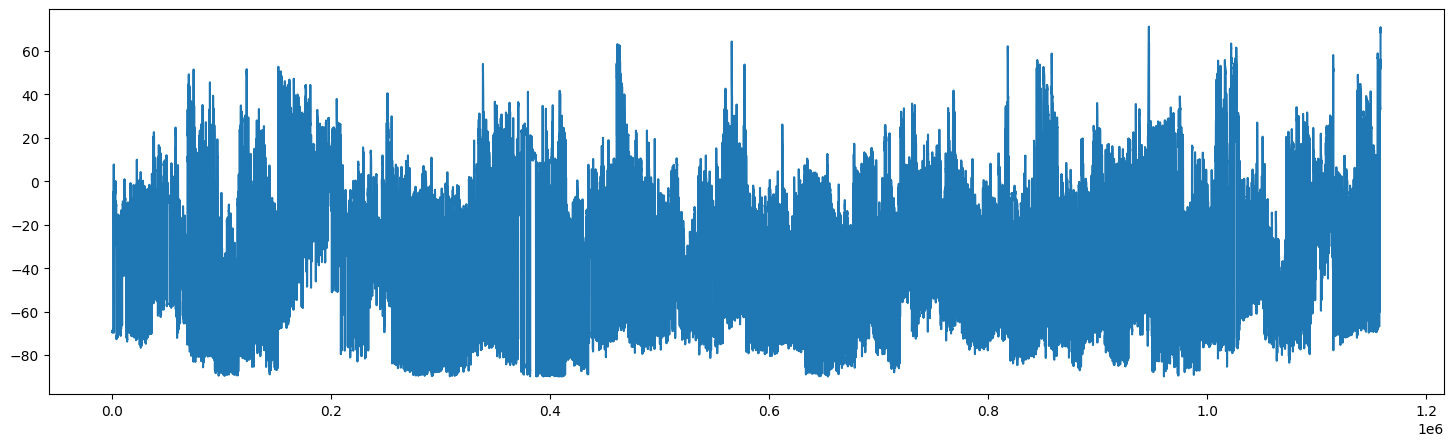

In [17]:
df['forearm_y_ang'].plot(figsize=(18, 5))


In [18]:
shoulder_quat = [
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['shoulder_y_ang'] = df[shoulder_quat].apply(calc_ang_to_Y, axis=1)
df['shoulder_y_ang'].head(5)


0   -68.904172
1   -68.904172
2   -68.827416
3   -68.827416
4   -68.628731
Name: shoulder_y_ang, dtype: float64

<Axes: >

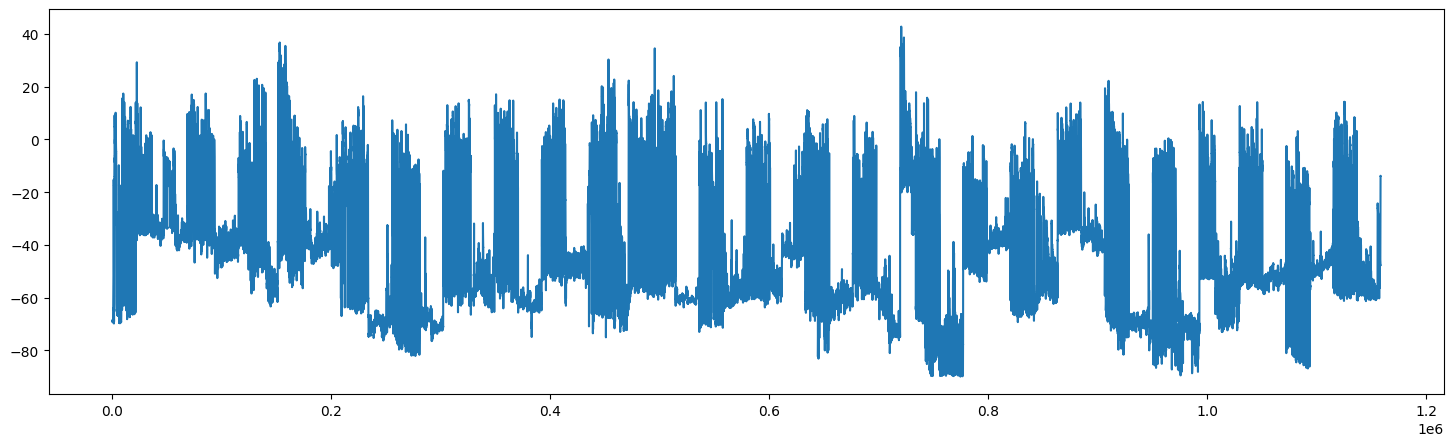

In [19]:
df['shoulder_y_ang'].plot(figsize=(18, 5))


In [20]:
def calc_forearm_shoulder_ang(row):
    forearm_rotation = scipy_transform.Rotation.from_quat(row.to_list()[:4])
    shoulder_rotation = scipy_transform.Rotation.from_quat(row.to_list()[4:])
    forearm_vec = forearm_rotation.apply([0, 1, 0])
    shoulder_vec = shoulder_rotation.apply([0, 1, 0])
    dot_product = np.dot(forearm_vec / np.linalg.norm(forearm_vec),
                         shoulder_vec / np.linalg.norm(shoulder_vec))
    rad_angle = np.arccos(dot_product)
    deg_angle = math.degrees(rad_angle)
    return deg_angle


In [21]:
forearm_shoulder_quats = [
    'forearm_quat_x',
    'forearm_quat_y',
    'forearm_quat_z',
    'forearm_quat_w',
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['forearm_shoulder_ang'] = df[forearm_shoulder_quats].apply(
    calc_forearm_shoulder_ang,
    axis=1
)
df['forearm_shoulder_ang'].head(5)


0    16.339390
1    16.339390
2    16.254618
3    16.254618
4    15.758679
Name: forearm_shoulder_ang, dtype: float64

<Axes: >

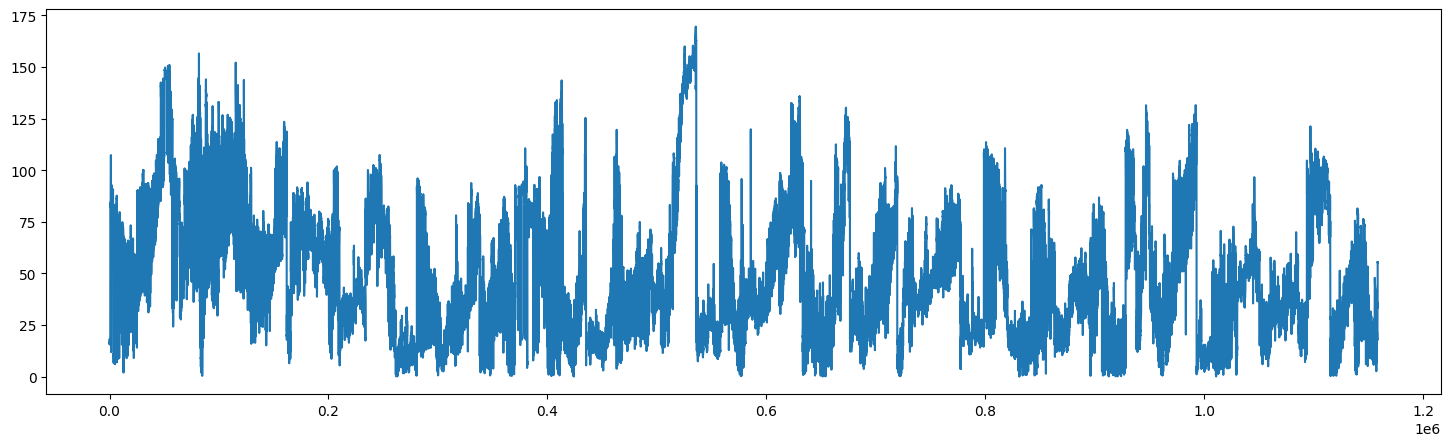

In [22]:
df['forearm_shoulder_ang'].plot(figsize=(18, 5))


# Calc lia features

<Axes: >

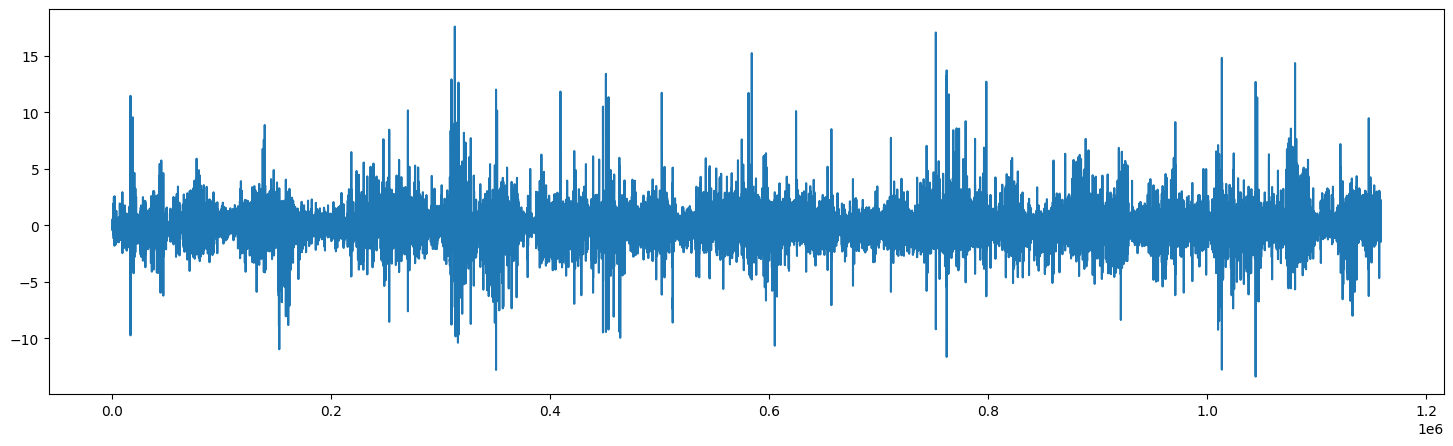

In [23]:
df['forearm_lia_x'] = df['forearm_lia_x'][abs(df['forearm_lia_x']) < 25]
df['forearm_lia_x'].plot(figsize=(18, 5))


<Axes: >

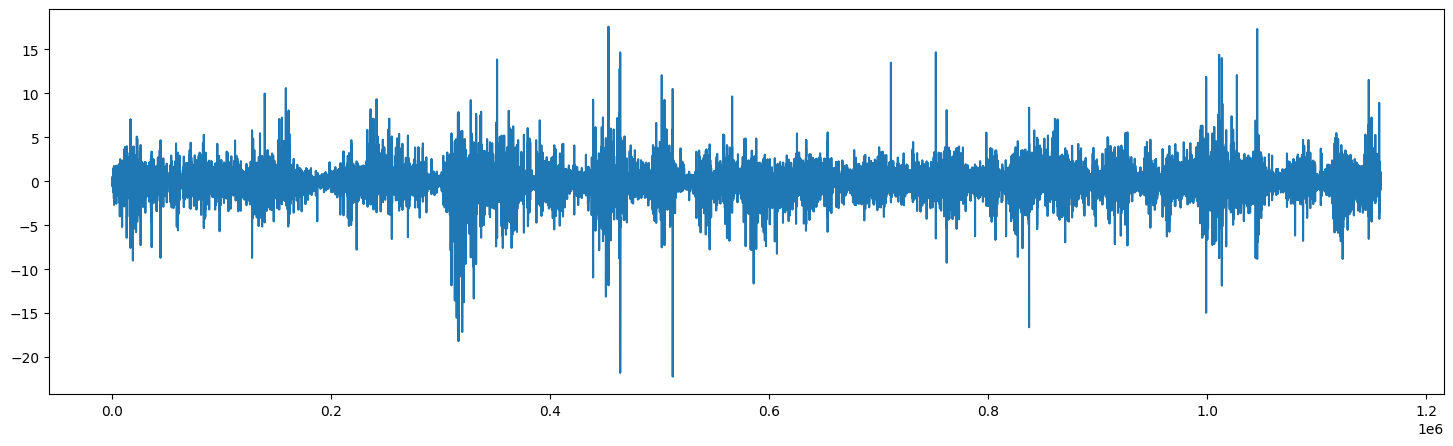

In [24]:
df['forearm_lia_y'] = df['forearm_lia_y'][abs(df['forearm_lia_y']) < 25]
df['forearm_lia_y'].plot(figsize=(18, 5))


<Axes: >

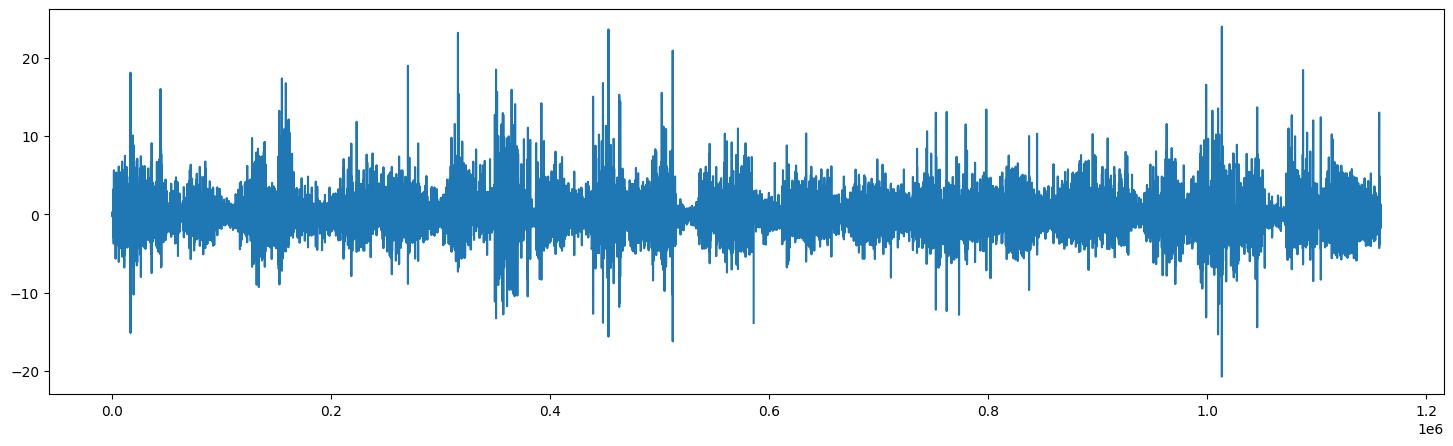

In [25]:
df['forearm_lia_z'] = df['forearm_lia_z'][abs(df['forearm_lia_z']) < 25]
df['forearm_lia_z'].plot(figsize=(18, 5))


<Axes: >

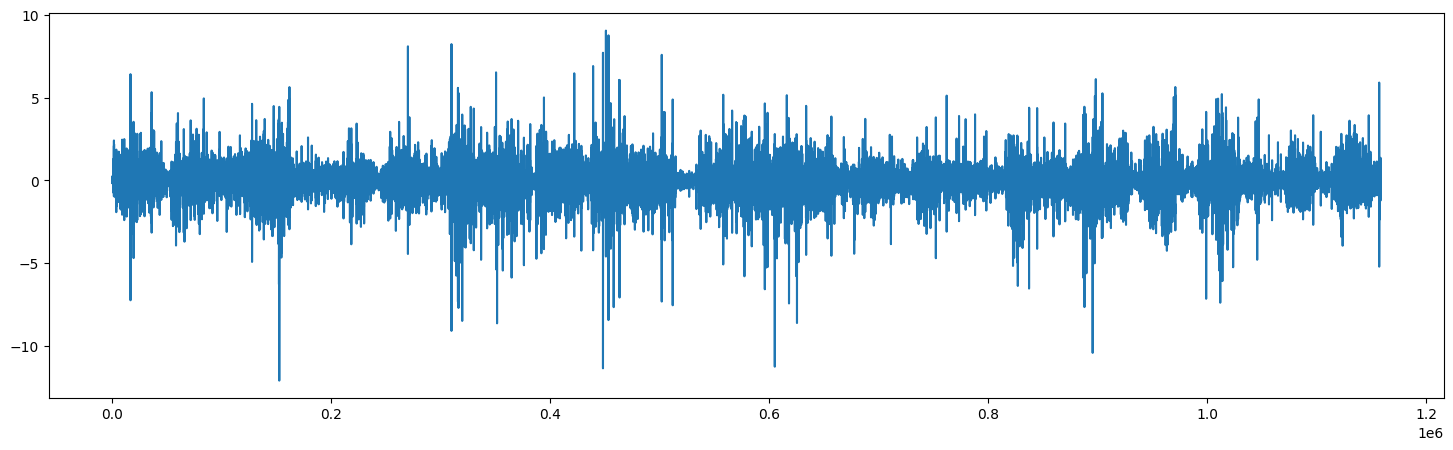

In [26]:
df['shoulder_lia_x'] = df['shoulder_lia_x'][abs(df['shoulder_lia_x']) < 25]
df['shoulder_lia_x'].plot(figsize=(18, 5))


<Axes: >

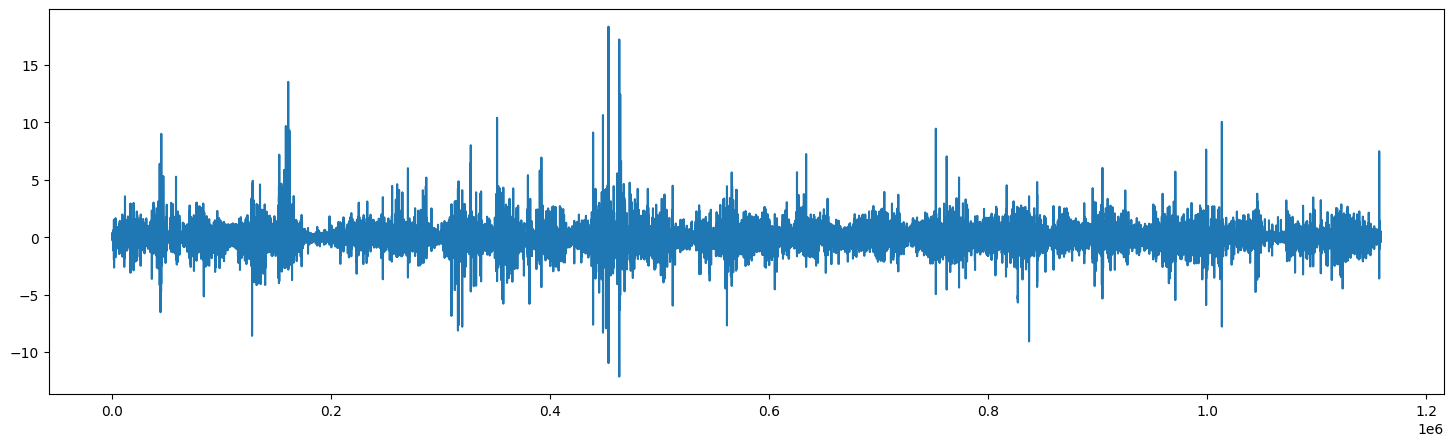

In [27]:
df['shoulder_lia_y'] = df['shoulder_lia_y'][abs(df['shoulder_lia_y']) < 25]
df['shoulder_lia_y'].plot(figsize=(18, 5))


<Axes: >

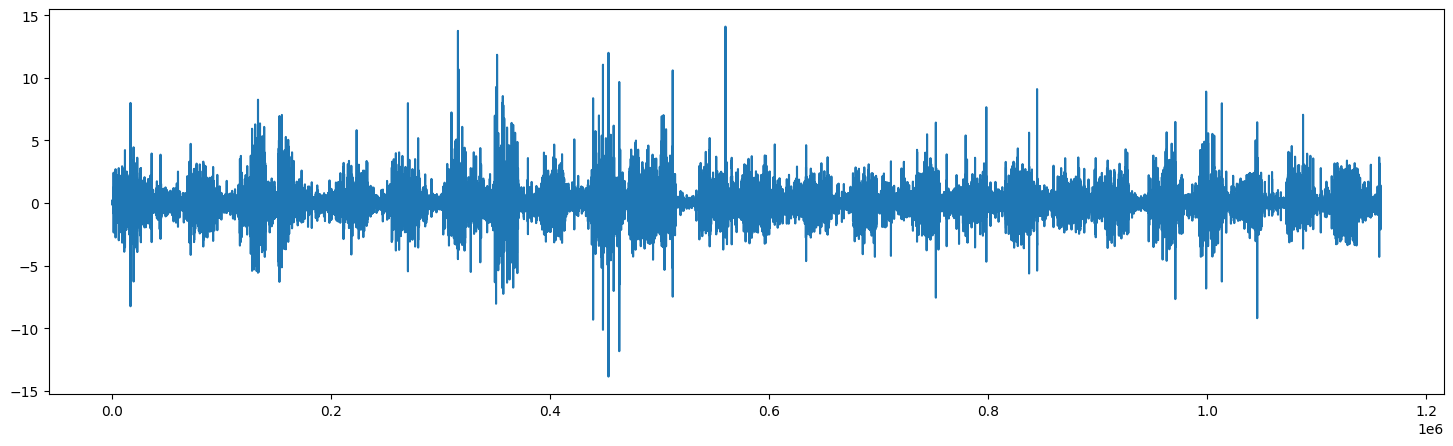

In [28]:
df['shoulder_lia_z'] = df['shoulder_lia_z'][abs(df['shoulder_lia_z']) < 25]
df['shoulder_lia_z'].plot(figsize=(18, 5))


# Discover game sessions

In [29]:
def plot_game_result(result_id, frame_range=(0, -1), save=False, positionType = None, new_figure=True):
    defprops = {
        'xdata': [],
        'ydata': [],
        'linestyle': 'None',
        'markersize': 10
    }
    black_arrow = mlines.Line2D(
        **defprops,
        marker='^',
        color='black',
        label='start position',
    )
    red_arrow = mlines.Line2D(
        **defprops,
        marker='v',
        color='red',
        label='end position',
    )
    plt.legend(handles=[black_arrow, red_arrow])

    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    result_df = result_df.iloc[frame_range[0]:frame_range[1]]

    assert len(exercise_ids := result_df['exercise_id'].unique()) == 1
    assert len(patient_ids := result_df['patient_id'].unique()) == 1
    assert len(game_ids := result_df['game_id'].unique()) == 1
    exercise_id = exercise_ids[0]
    patient_id = patient_ids[0]
    game_id = game_ids[0]

    # positionType = 1, labled by 'ArrowDown'. A hand in lower position.
    start_mark_locs = result_df.loc[result_df['fixed_position_type'] == 1].index
    # positionType = 2, labled by 'ArrowUp'. A hand in upper position.
    end_mark_locs = result_df.loc[result_df['fixed_position_type'] == 2].index

    if frame_range:
        start_mark_locs = [i - frame_range[0] for i in start_mark_locs]
        end_mark_locs = [i - frame_range[0] for i in end_mark_locs]

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}, exercise {exercise_id}, game {game_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='^',
        markersize=10,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    ax = result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='v',
        markersize=10,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    if save:
        fig = ax.get_figure()
        path = (
            (f'./charts/p{patient_id}_r{result_id}_e{exercise_id}') +
            (f'_{frame_range[0]}_{frame_range[1]}' if frame_range != (0, -1) else '') +
            (f'_{positionType}' if positionType else '')
        )
        fig.savefig(path, facecolor='#FFFFFF')
    if new_figure:
        plt.figure()


In [30]:
def plot_game_sessions(patient_id, save=False):
    patient_df = df.loc[df['patient_id'] == patient_id]
    result_ids = patient_df['game_result_id'].unique()
    print(result_ids)
    for result_id in result_ids:
        plot_game_result(result_id, save=save)


In [31]:
PATIENT_IDS = sorted(df['patient_id'].unique())
PATIENT_IDS


[231, 245, 377, 552, 588, 594, 612, 614, 618]

In [32]:
GAME_RESULT_IDS = sorted(df['game_result_id'].unique())
GAME_RESULT_IDS


[13237,
 13238,
 13239,
 13240,
 13241,
 13242,
 13243,
 13244,
 13245,
 13246,
 13247,
 13248,
 13249,
 13253,
 13254,
 13270,
 13273,
 13276,
 13278,
 13280,
 13282,
 13289,
 13318,
 13319,
 13320,
 13325,
 13371,
 13373,
 13387,
 13389,
 13391,
 13393,
 13394,
 13395,
 13396,
 13397,
 13439,
 13440,
 13441,
 13442,
 13458,
 13459,
 13460,
 13461,
 13475,
 13477,
 13478,
 13479,
 13486,
 13487,
 13495,
 13496,
 13497,
 13498,
 13504,
 13505,
 13506,
 13507,
 13513,
 13514,
 13515,
 13562,
 13563,
 13575,
 13576,
 13577,
 13578,
 13586,
 13589,
 13590,
 13591,
 13601,
 13604,
 13612,
 13613,
 13614,
 13615,
 13622,
 13624,
 13625,
 13627,
 13630,
 13631,
 13632,
 13633,
 13654,
 13655,
 13656,
 13657,
 13666,
 13668,
 13670,
 13672,
 13687,
 13689,
 13692,
 13695,
 13697,
 13699,
 13701,
 13703,
 13718,
 13719,
 13720,
 13721,
 13724,
 13725,
 13726,
 13727,
 13733,
 13734,
 13735,
 13736]

[13270]


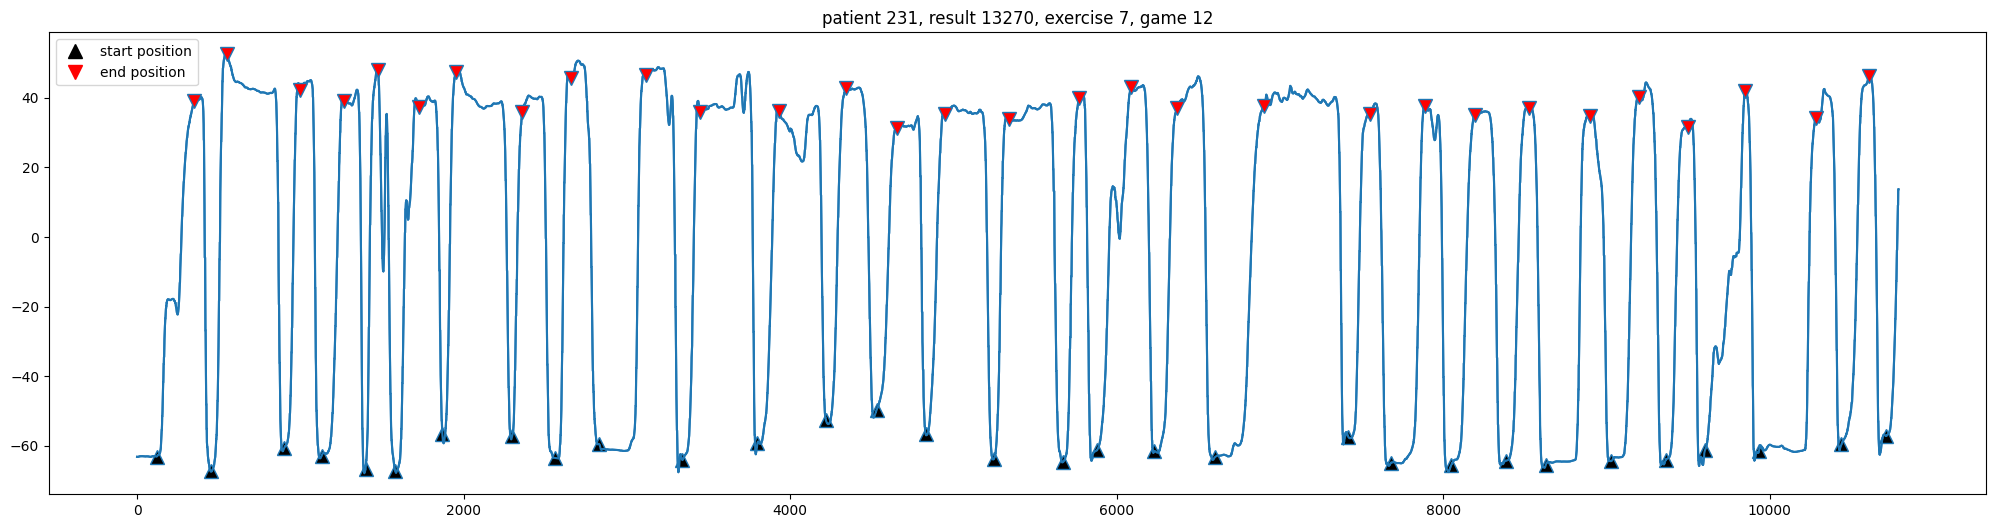

<Figure size 640x480 with 0 Axes>

In [33]:
# Others game sessions looks similar
for patient_id in PATIENT_IDS[:1]:
    plot_game_sessions(patient_id)


# Hypothesis 1
The model will work precicely, if it will have rolling windows based features that capture the "corner" of amplitude change or zone includes both sharp change of a sensor's angle to the Y axis, then moment where the angle stops to change sharply and then relatively flat zone. 

In [34]:
def get_mark_locs(studied_result_id):
    result_df = df.loc[df['game_result_id'] == studied_result_id].reset_index(drop=True)
    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['fixed_position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['fixed_position_type'] == 2].index
    return start_mark_locs, end_mark_locs


In [35]:
def plot_samples(result_id):
    start_mark_locs, end_mark_locs = get_mark_locs(result_id)
    plt.figure()
    for mark_loc in start_mark_locs:
        frame_range = (max(0, mark_loc - 45), mark_loc + 15)
        plot_game_result(result_id, frame_range, save=True, positionType='start', new_figure=False)
    plt.figure()
    for mark_loc in end_mark_locs:
        frame_range = (max(0, mark_loc - 55), mark_loc + 10)
        plot_game_result(result_id, frame_range, save=True, positionType='end', new_figure=False)


## Windows size detection

In [36]:
studied_patient_id = PATIENT_IDS[4]
studied_patient_id


588

In [37]:
result_ids = df.loc[df['patient_id'] == studied_patient_id]['game_result_id'].unique()
result_ids


array([13237, 13238, 13239, 13240, 13241, 13242, 13439, 13440, 13441,
       13442, 13562, 13563, 13654, 13655, 13656, 13657], dtype=int64)

In [38]:
# plot_samples(result_ids[8])


## Data labeling
Optimal window size is 70

In [39]:
def mark_ranges():
    df['position_type_window'] = 0

    # 'ArrowDown' positionType = 1;
    start_mark_locs = df.loc[df['position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = df.loc[df['position_type'] == 2].index

    for mark_loc in start_mark_locs:
        df.loc[max(mark_loc - 45, 0): mark_loc + 15, 'position_type_window'] = 1
    for mark_loc in end_mark_locs:
        df.loc[max(mark_loc - 55, 0): mark_loc + 10, 'position_type_window'] = 2


In [40]:
mark_ranges()
df['position_type_window'].head(5)


0    0
1    0
2    0
3    0
4    0
Name: position_type_window, dtype: int64

In [41]:
def plot_mark_ranges(result_id, key='position_type_window'):
    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    # result_df = result_df.iloc[0:2500]

    patient_ids = result_df['patient_id'].unique()
    assert len(patient_ids) == 1
    patient_id = patient_ids[0]

    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df[key] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df[key] == 2].index

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    plt.figure()


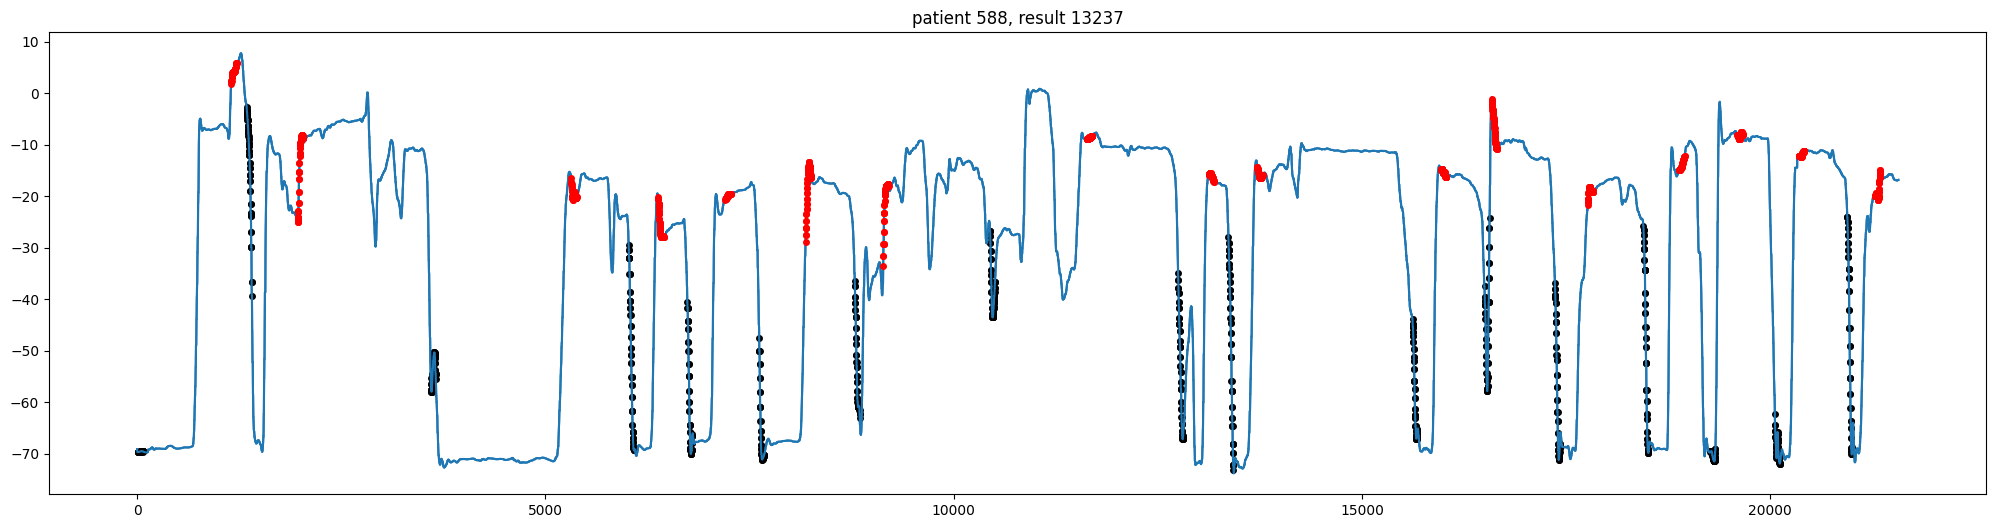

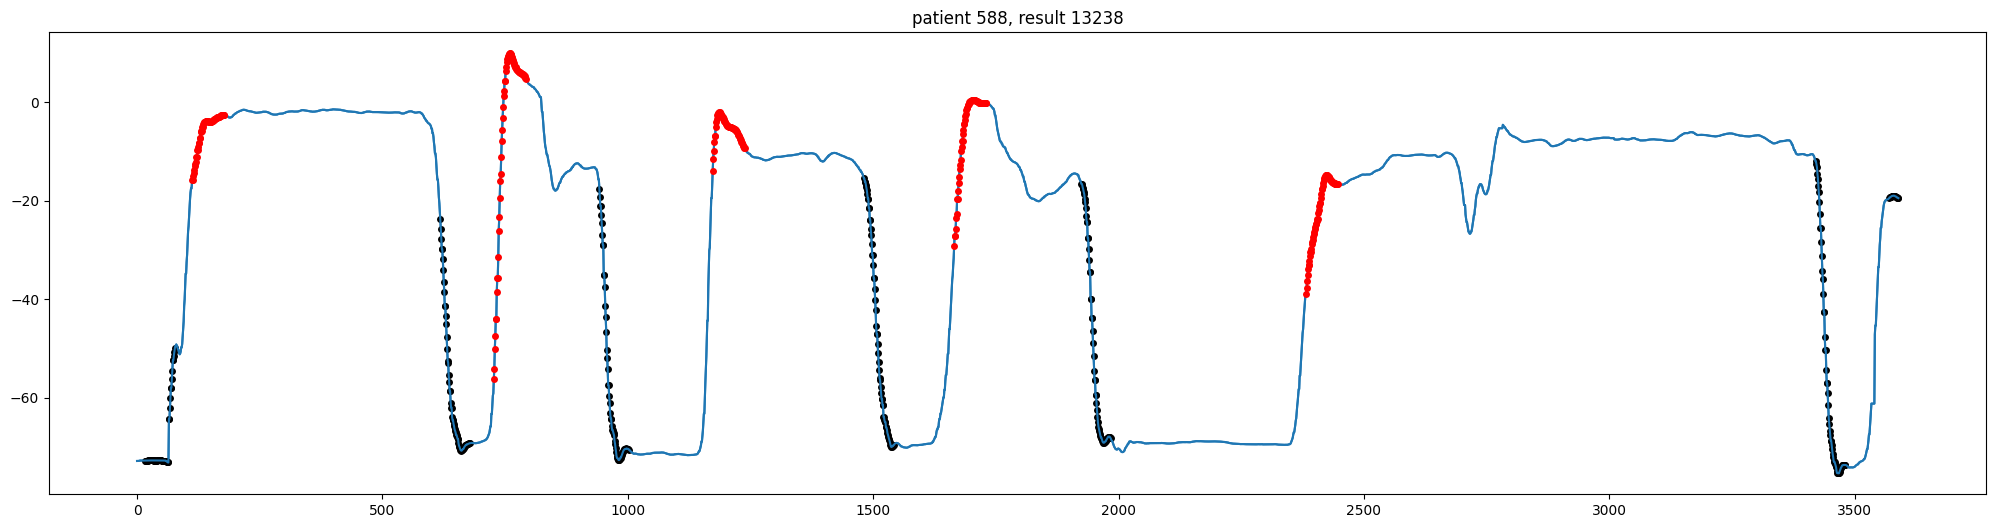

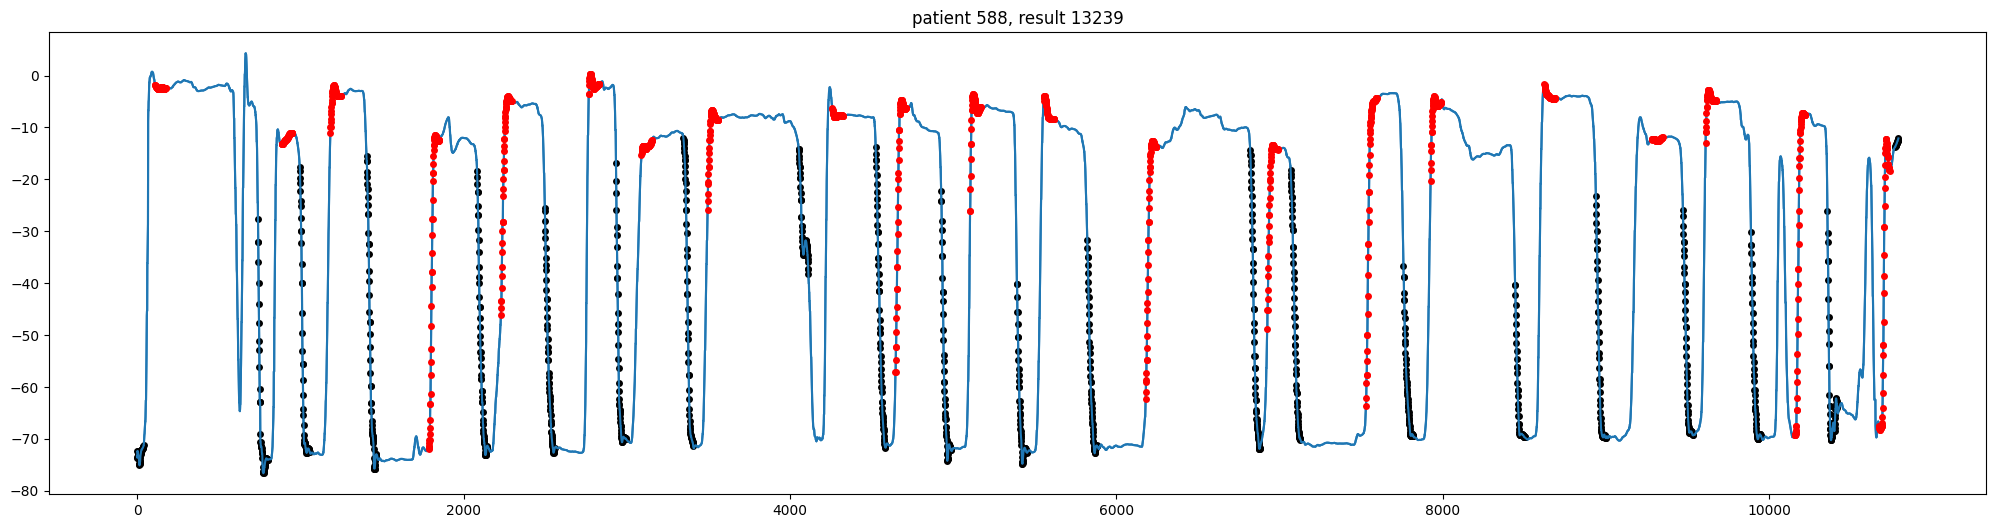

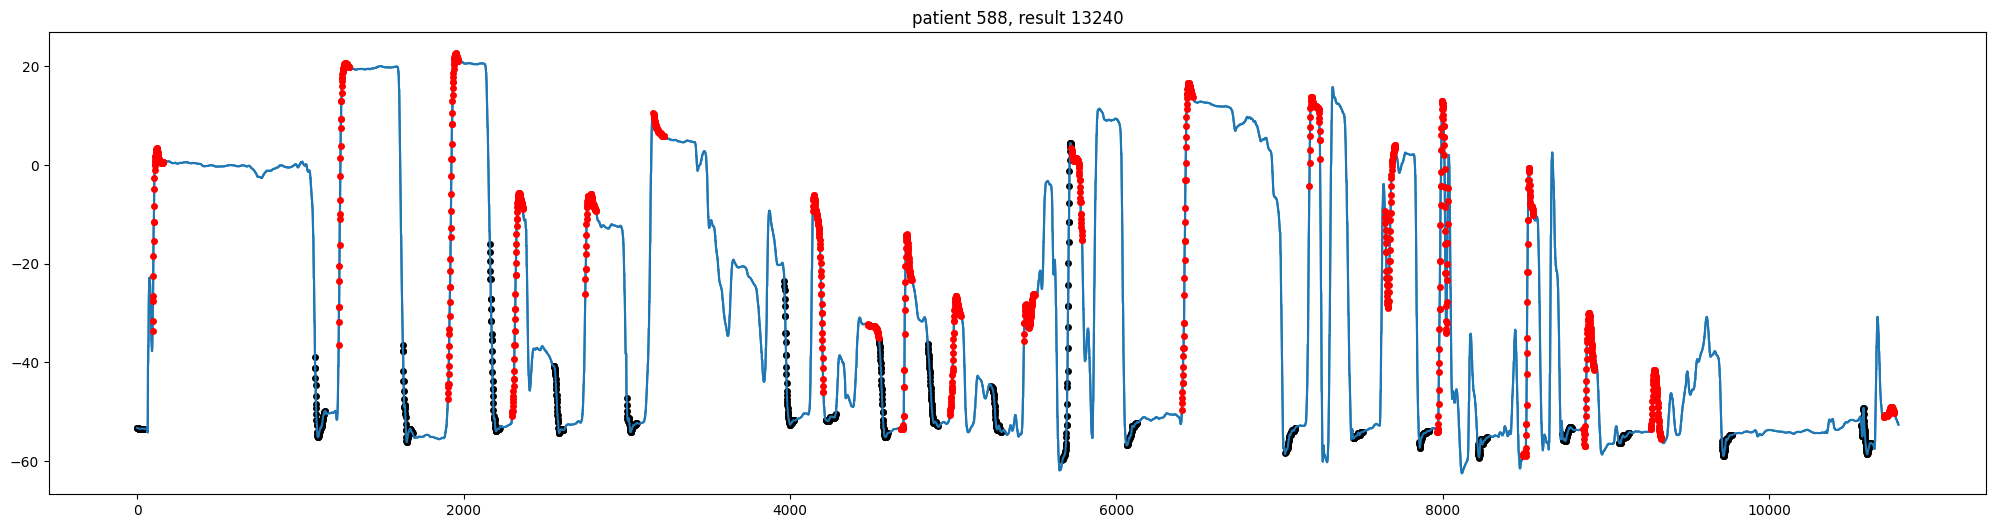

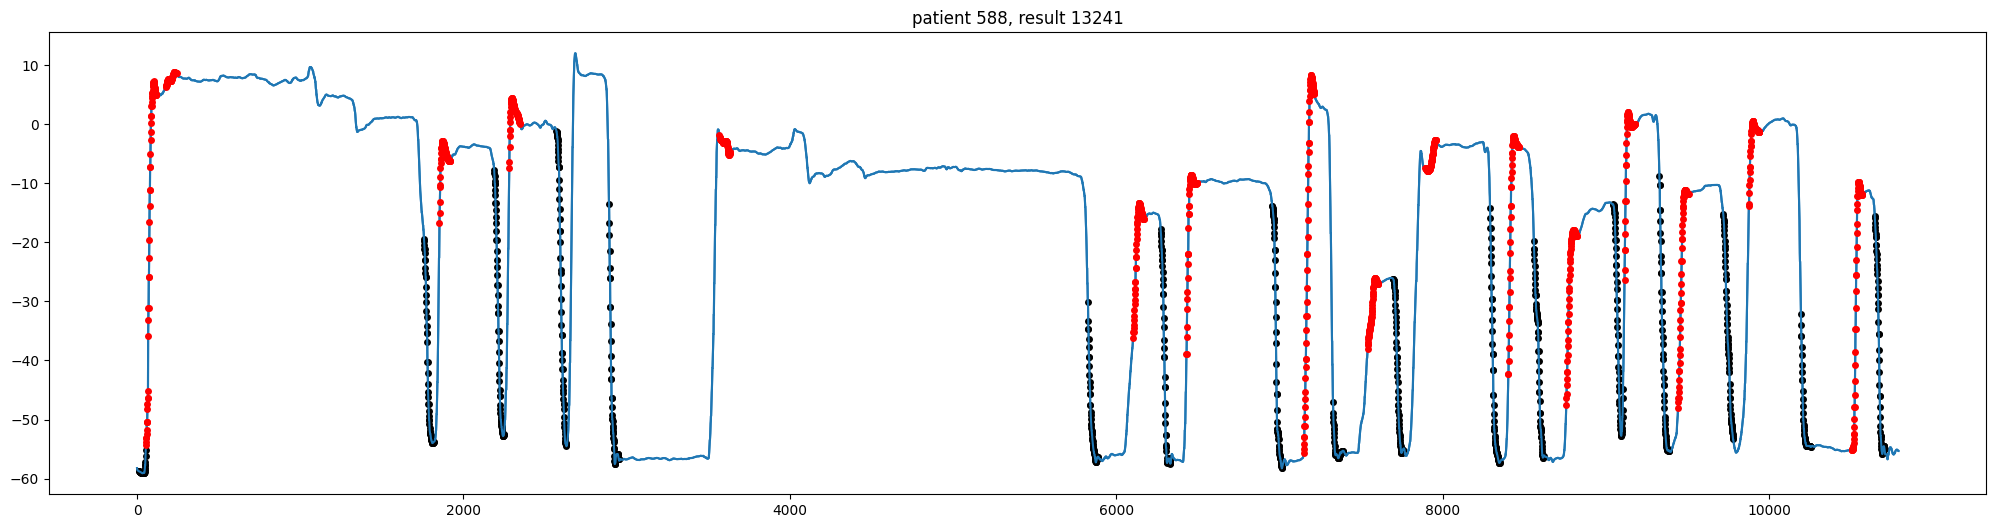

<Figure size 640x480 with 0 Axes>

In [42]:
for result_id in GAME_RESULT_IDS[:5]:
    plot_mark_ranges(result_id)


## Feature Extration

**Discrete:**
- ~~Угол между 2-мя датчиками~~
- ~~Разность между текущим углом и углом между сенсорами в предыдущем распознанном исходном положении~~
- ~~Разность между текущим и средним углом между сенсорами~~

**Window based:**
- ~~forearm_y_ang_rolling_10_mean~~
- ~~forearm_shoulder_ang_rolling_10_mean~~
- ~~forearm_y_ang_rolling_130_std~~
- ~~forearm_shoulder_ang_rolling_130_std~~
- ~~forearm_y_ang_rolling_100_min~~
- ~~forearm_y_ang_rolling_100_max~~
- ~~forearm_y_ang_rolling_20_diff_curr_max~~
- ~~forearm_y_ang_rolling_20_diff_curr_min~~
- ~~forearm_y_ang_mean_rolling_130_diff_max_rolling_130~~
- ~~forearm_y_ang_mean_rolling_130_diff_min_rolling_130~~
- ~~forearm_y_ang_median_rolling_130~~
----------------------------------------------------------------------------
- Фичи волатильноти сигнала
- Количество переходов через 0 угловой скорости (смена знака скорости означает смену направления движения руки) за N предшествующих фреймов
- Количество и частота пиков угла между датчиками за N предшествующих фреймов



In [43]:
import random

def plot_feature(name):
    plot_num = 10
    start_range = random.randint(0, len(GAME_RESULT_IDS) - plot_num)
    end_range = plot_num + start_range
    for result_id in GAME_RESULT_IDS[start_range:end_range]:
        result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
        # result_df = result_df.iloc[0:2500]

        patient_ids = result_df['patient_id'].unique()
        assert len(patient_ids) == 1
        patient_id = patient_ids[0]

        # 'ArrowDown' positionType = 1;
        start_mark_locs = result_df.loc[result_df['position_type_window'] == 1].index
        # 'ArrowUp' positionType = 2;
        end_mark_locs = result_df.loc[result_df['position_type_window'] == 2].index

        result_df[name].plot(
            title=f'feature: {name}, patient: {patient_id}, result: {result_id}',
            figsize=(25, 6),
            color='tab:blue',
            marker='o',
            markeredgewidth=0,
            markersize=5,
            markerfacecolor='black',
            markevery=start_mark_locs,
        )
        result_df[name].plot(
            figsize=(25, 6),
            color='tab:blue',
            marker='o',
            markeredgewidth=0,
            markersize=5,
            markerfacecolor='red',
            markevery=end_mark_locs,
        )
        plt.figure()


### forearm_y_ang_rolling_10_mean

In [44]:
df['forearm_y_ang_rolling_10_mean'] = df.groupby('game_result_id')['forearm_y_ang'].rolling(10).mean().reset_index(level=0, drop=True)


In [45]:
# plot_feature('forearm_y_ang_rolling_10_mean')


### shoulder_y_ang_rolling_10_mean

In [46]:
df['shoulder_y_ang_rolling_10_mean'] = df.groupby('game_result_id')['shoulder_y_ang'].rolling(10).mean().reset_index(level=0, drop=True)


In [47]:
# plot_feature('shoulder_y_ang_rolling_10_mean')


### forearm_shoulder_ang_rolling_10_mean

In [48]:
df['forearm_shoulder_ang_rolling_10_mean'] = df.groupby('game_result_id')['forearm_shoulder_ang'].rolling(10).mean().reset_index(level=0, drop=True)


In [49]:
# plot_feature('forearm_shoulder_ang_rolling_10_mean')


### forearm_direction

In [50]:
df['forearm_direction'] = df.groupby('game_result_id')['forearm_y_ang_rolling_10_mean'].transform(lambda x: x - x.shift())


### shoulder_direction

In [51]:
df['shoulder_direction'] = df.groupby('game_result_id')['shoulder_y_ang_rolling_10_mean'].transform(lambda x: x - x.shift())
# plot_feature('shoulder_direction')


### forearm_shoulder_direction

In [52]:
df['forearm_shoulder_direction'] = df.groupby('game_result_id')['forearm_shoulder_ang_rolling_10_mean'].transform(lambda x: x - x.shift())
# plot_feature('forearm_shoulder_direction')


### forearm_y_ang_rolling_130_std_directed

In [53]:
# df['forearm_y_ang_rolling_130_std_directed'] = df['forearm_y_ang'].rolling(130).std() * np.sign(df['forearm_direction'])
df['forearm_y_ang_rolling_130_std_directed'] = df.groupby('game_result_id').apply(lambda x: x['forearm_y_ang'].rolling(130).std() * np.sign(x['forearm_direction'])).reset_index(level=0, drop=True)
# plot_feature('forearm_y_ang_rolling_130_std_directed')


### shoulder_y_ang_rolling_130_std

In [54]:
# df['shoulder_y_ang_rolling_130_std_directed'] = df['shoulder_y_ang'].rolling(130).std() * np.sign(df['shoulder_direction'])
df['shoulder_y_ang_rolling_130_std_directed'] = df.groupby('game_result_id').apply(lambda x: x['shoulder_y_ang'].rolling(130).std() * np.sign(x['shoulder_y_ang'])).reset_index(level=0, drop=True)


In [55]:
# plot_feature('shoulder_y_ang_rolling_130_std_directed')


### forearm_shoulder_ang_rolling_130_std_directed

In [56]:
# df['forearm_shoulder_ang_rolling_130_std_directed'] = df['forearm_shoulder_ang'].rolling(130).std() * np.sign(df['forearm_shoulder_direction'])
df['forearm_shoulder_ang_rolling_130_std_directed'] = df.groupby('game_result_id').apply(lambda x: x['forearm_shoulder_ang'].rolling(130).std() * np.sign(x['forearm_shoulder_direction'])).reset_index(level=0, drop=True)


In [57]:
# plot_feature('forearm_shoulder_ang_rolling_130_std_directed')


### forearm_y_ang_rolling_100_min

In [58]:
# df['forearm_y_ang_rolling_100_min'] = df['forearm_y_ang'].rolling(100).min()
df['forearm_y_ang_rolling_100_min_'] = df.groupby('game_result_id')['forearm_y_ang'].rolling(100).min().reset_index(level=0, drop=True)


In [59]:
# plot_feature('forearm_y_ang_rolling_100_min')


### forearm_shoulder_ang_rolling_100_min

In [60]:
df['forearm_shoulder_ang_rolling_100_min'] = df.groupby('game_result_id')['forearm_shoulder_ang'].rolling(100).min().reset_index(level=0, drop=True)


In [61]:
# plot_feature('forearm_shoulder_ang_rolling_100_min')


### shoulder_y_ang_rolling_100_min

In [62]:
df['shoulder_y_ang_rolling_100_min'] = df.groupby('game_result_id')['shoulder_y_ang'].rolling(100).min().reset_index(level=0, drop=True)


In [63]:
# plot_feature('shoulder_y_ang_rolling_100_min')


### forearm_y_ang_rolling_100_max

In [64]:
df['forearm_y_ang_rolling_100_max'] = df.groupby('game_result_id')['forearm_y_ang'].rolling(100).max().reset_index(level=0, drop=True)


In [65]:
# plot_feature('forearm_y_ang_rolling_100_max')


### shoulder_y_ang_rolling_100_max

In [66]:
df['shoulder_y_ang_rolling_100_max'] = df.groupby('game_result_id')['shoulder_y_ang'].rolling(100).max().reset_index(level=0, drop=True)


In [67]:
# plot_feature('shoulder_y_ang_rolling_100_max')


### forearm_shoulder_ang_rolling_100_max

In [68]:
df['forearm_shoulder_ang_rolling_100_max'] = df.groupby('game_result_id')['forearm_shoulder_ang'].rolling(100).max().reset_index(level=0, drop=True)


In [69]:
# plot_feature('forearm_shoulder_ang_rolling_100_max')


### forearm_y_ang_rolling_20_diff_curr_max

In [70]:
# df['forearm_y_ang_rolling_20_diff_curr_max'] = df['forearm_y_ang'] - df['forearm_y_ang'].rolling(20).max()
df['forearm_y_ang_rolling_20_diff_curr_max'] = df.groupby('game_result_id').apply(lambda x: x['forearm_y_ang'] - x['forearm_y_ang'].rolling(20).max()).reset_index(level=0, drop=True)


In [71]:
df.loc[df['game_result_id'] == GAME_RESULT_IDS[-3],'forearm_y_ang_rolling_20_diff_curr_max'].head(22)


1125905         NaN
1125906         NaN
1125907         NaN
1125908         NaN
1125909         NaN
1125910         NaN
1125911         NaN
1125912         NaN
1125913         NaN
1125914         NaN
1125915         NaN
1125916         NaN
1125917         NaN
1125918         NaN
1125919         NaN
1125920         NaN
1125921         NaN
1125922         NaN
1125923         NaN
1125924   -0.083226
1125925   -0.060514
1125926   -0.054410
Name: forearm_y_ang_rolling_20_diff_curr_max, dtype: float64

In [72]:
# plot_feature('forearm_y_ang_rolling_20_diff_curr_max')


### shoulder_y_ang_rolling_20_diff_curr_max

In [73]:
# df['shoulder_y_ang_rolling_20_diff_curr_max'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].rolling(20).max()
df['shoulder_y_ang_rolling_20_diff_curr_max'] = df.groupby('game_result_id').apply(lambda x: x['shoulder_y_ang'] - x['shoulder_y_ang'].rolling(20).max()).reset_index(level=0, drop=True)


In [74]:
# plot_feature('shoulder_y_ang_rolling_20_diff_curr_max')


### forearm_shoulder_ang_rolling_20_diff_curr_max

In [75]:
# df['forearm_shoulder_ang_rolling_20_diff_curr_max'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].rolling(20).max()
df['forearm_shoulder_ang_rolling_20_diff_curr_max'] = df.groupby('game_result_id').apply(lambda x: x['forearm_shoulder_ang'] - x['forearm_shoulder_ang'].rolling(20).max()).reset_index(level=0, drop=True)


In [76]:
# plot_feature('forearm_shoulder_ang_rolling_20_diff_curr_max')


### forearm_y_ang_rolling_20_diff_curr_min

In [77]:
# df['forearm_y_ang_rolling_20_diff_curr_min'] = df['forearm_y_ang'] - df['forearm_y_ang'].rolling(20).min()
df['forearm_y_ang_rolling_20_diff_curr_min'] = df.groupby('game_result_id').apply(lambda x: x['forearm_y_ang'] - x['forearm_y_ang'].rolling(20).min()).reset_index(level=0, drop=True)


In [78]:
# plot_feature('forearm_y_ang_rolling_20_diff_curr_min')


### shoulder_y_ang_rolling_20_diff_curr_min

In [79]:
# df['shoulder_y_ang_rolling_20_diff_curr_min'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].rolling(20).min()
df['shoulder_y_ang_rolling_20_diff_curr_min'] = df.groupby('game_result_id').apply(lambda x: x['shoulder_y_ang'] - x['shoulder_y_ang'].rolling(20).min()).reset_index(level=0, drop=True)
# plot_feature('shoulder_y_ang_rolling_20_diff_curr_min')


### forearm_shoulder_ang_rolling_20_diff_curr_min

In [80]:
# df['forearm_shoulder_ang_rolling_20_diff_curr_min'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].rolling(20).min()
df['forearm_shoulder_ang_rolling_20_diff_curr_min'] = df.groupby('game_result_id').apply(lambda x: x['forearm_shoulder_ang'] - x['forearm_shoulder_ang'].rolling(20).min()).reset_index(level=0, drop=True)

# plot_feature('forearm_shoulder_ang_rolling_20_diff_curr_min')


### forearm_y_ang_diff_max_rolling_100_min_rolling_10

In [81]:
# df['forearm_y_ang_diff_max_rolling_100_min_rolling_10'] = df['forearm_y_ang'].rolling(100).max() - df['forearm_y_ang'].rolling(10).min()
df['forearm_y_ang_diff_max_rolling_100_min_rolling_10'] = df.groupby('game_result_id').apply(lambda x: x['forearm_y_ang'].rolling(100).max() - x['forearm_y_ang'].rolling(10).min()).reset_index(level=0, drop=True)
# plot_feature('forearm_y_ang_diff_max_rolling_100_min_rolling_10')


### forearm_y_ang_diff_min_rolling_100_max_rolling_10

In [82]:
# df['forearm_y_ang_diff_min_rolling_100_max_rolling_10'] = df['forearm_y_ang'].rolling(100).max() - df['forearm_y_ang'].rolling(10).min()
df['forearm_y_ang_diff_min_rolling_100_max_rolling_10'] = df.groupby('game_result_id').apply(lambda x: x['forearm_y_ang'].rolling(100).max() - x['forearm_y_ang'].rolling(10).min()).reset_index(level=0, drop=True)

# plot_feature('forearm_y_ang_diff_min_rolling_100_max_rolling_10')


### forearm_y_ang_mean_rolling_130_diff_min_rolling_130

In [83]:
# df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130'] = df['forearm_y_ang'].rolling(130).mean() - df['forearm_y_ang'].rolling(130).min()
df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130'] = df.groupby('game_result_id').apply(lambda x: x['forearm_y_ang'].rolling(130).mean() - x['forearm_y_ang'].rolling(130).min()).reset_index(level=0, drop=True)
# plot_feature('forearm_y_ang_mean_rolling_130_diff_min_rolling_130')


### forearm_y_ang_mean_rolling_130_diff_max_rolling_130

In [84]:
# df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130'] = df['forearm_y_ang'].rolling(130).mean() - df['forearm_y_ang'].rolling(130).max()
df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130'] = df.groupby('game_result_id').apply(lambda x: x['forearm_y_ang'].rolling(130).mean() - x['forearm_y_ang'].rolling(130).max()).reset_index(level=0, drop=True)

# plot_feature('forearm_y_ang_mean_rolling_130_diff_max_rolling_130')


### forearm_y_ang_median_rolling_130

In [85]:
df['forearm_y_ang_median_rolling_130'] = df.groupby('game_result_id')['forearm_y_ang'].rolling(130).median().reset_index(level=0, drop=True)
# plot_feature('forearm_y_ang_median_rolling_130')


### shoulder_y_ang_median_rolling_130

In [86]:
df['shoulder_y_ang_median_rolling_130'] = df.groupby('game_result_id')['shoulder_y_ang'].rolling(130).median().reset_index(level=0, drop=True)
# plot_feature('shoulder_y_ang_median_rolling_130')


### forearm_lia_x_mean_rolling_130

In [87]:
df['forearm_lia_x_mean_rolling_130'] = df.groupby('game_result_id')['forearm_lia_x'].rolling(130).mean().reset_index(level=0, drop=True)
# plot_feature('forearm_lia_x_mean_rolling_130')


### shoulder_lia_x_mean_rolling_130

In [88]:
df['shoulder_lia_x_mean_rolling_130'] = df.groupby('game_result_id')['forearm_lia_x'].rolling(130).mean().reset_index(level=0, drop=True)
# plot_feature('shoulder_lia_x_mean_rolling_130')


### forearm_lia_y_mean_rolling_130

In [89]:
df['forearm_lia_y_mean_rolling_130'] = df.groupby('game_result_id')['forearm_lia_y'].rolling(130).mean().reset_index(level=0, drop=True)
# plot_feature('forearm_lia_y_mean_rolling_130')


### shoulder_lia_y_mean_rolling_130

In [90]:
df['shoulder_lia_y_mean_rolling_130'] = df.groupby('game_result_id')['forearm_lia_y'].rolling(130).mean().reset_index(level=0, drop=True)
# plot_feature('shoulder_lia_y_mean_rolling_130')


### forearm_lia_z_mean_rolling_130

In [91]:
df['forearm_lia_z_mean_rolling_130'] = df.groupby('game_result_id')['forearm_lia_z'].rolling(130).mean().reset_index(level=0, drop=True)
# plot_feature('forearm_lia_z_mean_rolling_130')


### shoulder_lia_z_mean_rolling_130

In [92]:
df['shoulder_lia_z_mean_rolling_130'] = df.groupby('game_result_id')['forearm_lia_z'].rolling(130).mean().reset_index(level=0, drop=True)
# plot_feature('shoulder_lia_z_mean_rolling_130')


### forearm_lia_x_median_rolling_130

In [93]:
df['forearm_lia_x_median_rolling_130'] = df.groupby('game_result_id')['forearm_lia_x'].rolling(130).median().reset_index(level=0, drop=True)
# plot_feature('forearm_lia_x_median_rolling_130')


### forearm_lia_y_median_rolling_30

In [94]:
df['forearm_lia_y_median_rolling_30'] = df.groupby('game_result_id')['forearm_lia_y'].rolling(30).median().reset_index(level=0, drop=True)
# plot_feature('forearm_lia_y_median_rolling_30')


### forearm_lia_z_median_rolling_130

In [95]:
df['forearm_lia_z_median_rolling_130'] = df.groupby('game_result_id')['forearm_lia_z'].rolling(130).median().reset_index(level=0, drop=True)
# plot_feature('forearm_lia_z_median_rolling_130')


### forearm_y_ang_curr_diff_shift_10

In [96]:
# df['forearm_y_ang_curr_diff_shift_10'] = df['forearm_y_ang'] - df['forearm_y_ang'].shift(10)
df['forearm_y_ang_curr_diff_shift_10'] = df.groupby('game_result_id')['forearm_y_ang'].transform(lambda x: x - x.shift(10))
# plot_feature('forearm_y_ang_curr_diff_shift_10')


### shoulder_y_ang_curr_diff_shift_10

In [97]:
# df['shoulder_y_ang_curr_diff_shift_10'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].shift(10)
df['shoulder_y_ang_curr_diff_shift_10'] = df.groupby('game_result_id')['shoulder_y_ang'].transform(lambda x: x - x.shift(10))
# plot_feature('shoulder_y_ang_curr_diff_shift_10')


### forearm_shoulder_ang_curr_diff_shift_10

In [98]:
# df['forearm_shoulder_ang_curr_diff_shift_10'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].shift(10)
df['forearm_shoulder_ang_curr_diff_shift_10'] = df.groupby('game_result_id')['forearm_shoulder_ang'].transform(lambda x: x - x.shift(10))
# plot_feature('forearm_shoulder_ang_curr_diff_shift_10')


### forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30

In [99]:
df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30'] = df.groupby('game_result_id')['forearm_y_ang_mean_rolling_130_diff_max_rolling_130'].rolling(30).std().reset_index(level=0, drop=True)
# plot_feature('forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30')


### forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30

In [100]:
df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30'] = df.groupby('game_result_id')['forearm_y_ang_mean_rolling_130_diff_min_rolling_130'].rolling(30).std().reset_index(level=0, drop=True)
# plot_feature('forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30')


In [101]:


df['shoulder_lia_z_rolling_100_min'] = df.groupby('game_result_id')['shoulder_lia_z'].rolling(100).min().reset_index(level=0, drop=True)
df['forearm_lia_z_rolling_100_max'] = df.groupby('game_result_id')['forearm_lia_z'].rolling(100).max().reset_index(level=0, drop=True)



In [102]:
df['forearm_lia_z_rolling_100_min'] = df.groupby('game_result_id')['forearm_lia_z'].rolling(100).min().reset_index(level=0, drop=True)
df['forearm_lia_z_rolling_20_diff_curr_max'] = df.groupby('game_result_id').apply(lambda x: x['forearm_lia_z'] - x['forearm_lia_z'].rolling(20).max()).reset_index(level=0, drop=True)
df['shoulder_lia_z_rolling_20_diff_curr_max'] = df.groupby('game_result_id').apply(lambda x: x['shoulder_lia_z'] - x['shoulder_lia_z'].rolling(20).max()).reset_index(level=0, drop=True)
df['shoulder_lia_z_rolling_10_mean'] = df.groupby('game_result_id')['shoulder_lia_z'].rolling(10).mean().reset_index(level=0, drop=True)
df['forearm_lia_z_rolling_10_mean'] = df.groupby('game_result_id')['forearm_lia_z'].rolling(10).mean().reset_index(level=0, drop=True)
df['shoulder_lia_z_direction'] = df.groupby('game_result_id')['shoulder_lia_z_rolling_10_mean'].transform(lambda x: x - x.shift())
df['forearm_lia_z_direction'] = df.groupby('game_result_id')['forearm_lia_z_rolling_10_mean'].transform(lambda x: x - x.shift())
df['shoulder_lia_z_rolling_100_max'] = df.groupby('game_result_id')['shoulder_lia_z'].rolling(100).max().reset_index(level=0, drop=True)
df['forearm_lia_z_rolling_100_max'] = df.groupby('game_result_id')['forearm_lia_z'].rolling(100).max().reset_index(level=0, drop=True)

## Model selection

### XGBoost

In [103]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score


In [104]:
EXCLUDE_CLOS = [
    'position_type_window',
    'fixed_position_type',
    'position_type',
    'timestamp',
    'src',
    'forearm_tilt',
    'shoulder_tilt',
    'side',
    'patient_id',
    'game_id',
    'game_result_id',
]

X_columns = list(filter(lambda x: x not in EXCLUDE_CLOS, df.columns))
X_columns


['exercise_id',
 'h_rssi',
 'h_gain',
 'g_rssi',
 'g_gain',
 'forearm_quat_x',
 'forearm_quat_y',
 'forearm_quat_z',
 'forearm_quat_w',
 'forearm_lia_x',
 'forearm_lia_y',
 'forearm_lia_z',
 'forearm_grv_x',
 'forearm_grv_y',
 'forearm_grv_z',
 'shoulder_quat_x',
 'shoulder_quat_y',
 'shoulder_quat_z',
 'shoulder_quat_w',
 'shoulder_lia_x',
 'shoulder_lia_y',
 'shoulder_lia_z',
 'shoulder_grv_x',
 'shoulder_grv_y',
 'shoulder_grv_z',
 'forearm_y_ang',
 'shoulder_y_ang',
 'forearm_shoulder_ang',
 'forearm_y_ang_rolling_10_mean',
 'shoulder_y_ang_rolling_10_mean',
 'forearm_shoulder_ang_rolling_10_mean',
 'forearm_direction',
 'shoulder_direction',
 'forearm_shoulder_direction',
 'forearm_y_ang_rolling_130_std_directed',
 'shoulder_y_ang_rolling_130_std_directed',
 'forearm_shoulder_ang_rolling_130_std_directed',
 'forearm_y_ang_rolling_100_min_',
 'forearm_shoulder_ang_rolling_100_min',
 'shoulder_y_ang_rolling_100_min',
 'forearm_y_ang_rolling_100_max',
 'shoulder_y_ang_rolling_100_max

In [105]:
len(GAME_RESULT_IDS)


113

In [106]:
count_type = lambda x: len(df.loc[df['position_type_window'] == x])
count_type(0), count_type(1), count_type(2)


(911139, 119935, 127206)

In [107]:
X = df.loc[:, X_columns]
y = df.loc[:, 'position_type_window']


X_train = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:100]), X_columns]
y_train = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:100]), 'position_type_window']

X_test = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[100:-1]), X_columns]
y_test = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[100:-1]), 'position_type_window']


X_small = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), X_columns]
y_small = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), 'position_type_window']

X_small_val = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[10:15]), X_columns]
y_small_val = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[10:15]), 'position_type_window']

X_small_test = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[15:20]), X_columns]
y_small_test = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[15:20]), 'position_type_window']


In [108]:
df.loc[df['game_result_id'] == 13725, X_columns].to_csv('./data/features_result_13725.csv', index=False)
# df.loc[df['game_result_id'] == 13389, X_columns].to_csv('./data/features_result_13389.csv', index=False)


In [109]:
df.loc[df['game_result_id'] == 13725, X_columns].head()


,exercise_id,h_rssi,h_gain,g_rssi,g_gain,forearm_quat_x,forearm_quat_y,forearm_quat_z,forearm_quat_w,forearm_lia_x,...,shoulder_lia_z_rolling_100_min,forearm_lia_z_rolling_100_max,forearm_lia_z_rolling_100_min,forearm_lia_z_rolling_20_diff_curr_max,shoulder_lia_z_rolling_20_diff_curr_max,shoulder_lia_z_rolling_10_mean,forearm_lia_z_rolling_10_mean,shoulder_lia_z_direction,forearm_lia_z_direction,shoulder_lia_z_rolling_100_max
1082736,7,-99,0,0,0,0.438216,0.244256,0.623559,0.599566,-0.123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082737,7,-99,0,0,0,0.438216,0.244256,0.623559,0.599566,-0.123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082738,7,-99,0,0,0,0.438665,0.244622,0.623574,0.599073,-0.140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082739,7,-99,0,0,0,0.439061,0.244950,0.623701,0.598517,-0.148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082740,7,-99,0,0,0,0.439328,0.245234,0.623749,0.598153,-0.092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
N_SPLITS = 4


In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

gkfold = GroupKFold(n_splits=N_SPLITS)
gscv = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        'max_depth': [6, 8, 10],
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.5, 0.01],
    },
    cv=gkfold,
    scoring='accuracy',
    n_jobs=-1,
)
gscv.fit(
    X_small,
    y_small,
    groups=df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), 'game_result_id']
)
print(f"Accuracy: {gscv.best_score_:.2f} %, params: {gscv.best_params_}")


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
best_params_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
result = cross_val_score(model, X, y, cv=gkfold, groups=df['game_result_id'], n_jobs=N_SPLITS)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))
# Before data cleaning accuracy: 86.26% (0.48%)


Accuracy: 88.01% (0.40%)


### Random Forest

In [ ]:
X.isna().sum()


exercise_id                                                             0
h_rssi                                                                  0
h_gain                                                                  0
g_rssi                                                                  0
g_gain                                                                  0
                                                                     ... 
forearm_y_ang_curr_diff_shift_10                                       10
shoulder_y_ang_curr_diff_shift_10                                      10
forearm_shoulder_ang_curr_diff_shift_10                                10
forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30    158
forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30    158
Length: 69, dtype: int64

In [ ]:
X = X.fillna(0)
X_small = X_small.fillna(0)
assert not X.isna().any().any()
assert not X_small.isna().any().any()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

splitter = GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['game_result_id'])
train_inds, test_inds = next(split)

train_X_impts = df.loc[train_inds, X_columns]
train_y_impts = df.loc[train_inds, 'position_type_window']
test_X_impts = df.loc[test_inds, X_columns]
test_y_impts = df.loc[test_inds, 'position_type_window']

impts_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, nthread=-1)
impts_model.fit(train_X_impts, train_y_impts)

gkfold = GroupKFold(n_splits=N_SPLITS)
gscv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'max_depth': [6, 8, 10],
        'n_estimators': [50, 100]
    },
    cv=gkfold,
    scoring='accuracy',
    n_jobs=-1,
)
gscv.fit(
    X_small,
    y_small,
    groups=df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), 'game_result_id']
)
print(f"Accuracy: {gscv.best_score_:.2f} %, params: {gscv.best_params_}")


Accuracy: 0.83 %, params: {'max_depth': 10, 'n_estimators': 50}


In [ ]:
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=12)
result = cross_val_score(model, X, y, cv=gkfold, groups=df['game_result_id'], n_jobs=N_SPLITS)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))


Accuracy: 85.72% (0.67%)


### Decision tree

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

gkfold = GroupKFold(n_splits=N_SPLITS)
gscv = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'max_depth': [6, 8, 10],
    },
    cv=gkfold,
    scoring='accuracy',
    n_jobs=-1,
)
gscv.fit(X, y, groups=df['game_result_id'])
print(f"Accuracy: {gscv.best_score_:.2f} %, params: {gscv.best_params_}")


Accuracy: 0.84 %, params: {'max_depth': 8}


XGBoost is the best model with params: `{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}`

## Models split

In [112]:
df_ex7 = df.loc[df['exercise_id'] ==  7, :]
df_ex8 = df.loc[df['exercise_id'] ==  8, :]

EX7_GAME_RESULT_IDS = sorted(df_ex7['game_result_id'].unique())
EX8_GAME_RESULT_IDS = sorted(df_ex8['game_result_id'].unique())

len(EX7_GAME_RESULT_IDS), len(EX8_GAME_RESULT_IDS)


(64, 49)

In [113]:
X_ex7 = df_ex7.loc[:, X_columns]
y_ex7 = df_ex7.loc[:, 'position_type_window']

X_ex7_train = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[:61]), X_columns]
y_ex7_train = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[:61]), 'position_type_window']

X_ex7_test = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), X_columns]
y_ex7_test = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), 'position_type_window']


In [114]:
y_ex7_train.shape


(604263,)

In [115]:
X_ex8 = df_ex8.loc[:, X_columns]
y_ex8 = df_ex8.loc[:, 'position_type_window']

X_ex8_train = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[:47]), X_columns]
y_ex8_train = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[:47]), 'position_type_window']

X_ex8_test = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[47:-1]), X_columns]
y_ex8_test = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[47:-1]), 'position_type_window']


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex7_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
result = cross_val_score(
    ex7_cv_xgboost_model,
    X_ex7,
    y_ex7,
    cv=gkfold,
    groups=df_ex7['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))
# Before new features accuracy: 88.35% (0.86%)

Accuracy: 88.40% (0.81%)


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex8_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
ex8_result = cross_val_score(
    ex8_cv_xgboost_model,
    X_ex8,
    y_ex8,
    cv=gkfold,
    groups=df_ex8['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (ex8_result.mean()*100, ex8_result.std()*100))
# Before new features accuracy: 87.33% (1.06%)

Accuracy: 87.48% (0.72%)


## Filtering features

In [116]:
from sklearn.model_selection import GroupKFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def find_optimal_features(model, X, y, groups, exclude_percentage=0.3, output_file=None):
    gkfold = GroupKFold(n_splits=N_SPLITS)
    result = cross_val_score(model, X, y, cv=gkfold, groups=groups, n_jobs=N_SPLITS)

    model.fit(X, y)

    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    feature_names = X.columns

    excluded_indices = indices[int(exclude_percentage * X.shape[1]):]

    if output_file:
        with open(output_file, 'w') as f:
            f.write("Excluded Features:\n")
            for i in excluded_indices:
                f.write("%s\n" % feature_names[i])

    return result

In [ ]:
gkfold_ex7 = GroupKFold(n_splits=N_SPLITS)
ex7_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
ex7_result = find_optimal_features( ex7_cv_xgboost_model, X_ex7, y_ex7, groups=df_ex7['game_result_id'], output_file="ex7_excluded_features.txt")

print("Accuracy for ex7_cv_xgboost_model: %.2f%% (%.2f%%)" % (ex7_result.mean()*100, ex7_result.std() * 100))

C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

Accuracy for ex7_cv_xgboost_model: 88.42% (0.90%)


In [ ]:
gkfold_ex8 = GroupKFold(n_splits=N_SPLITS)
ex8_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
ex8_result = find_optimal_features( ex8_cv_xgboost_model, X_ex8, y_ex8, groups=df_ex8['game_result_id'], output_file="ex8_excluded_features.txt")

print("Accuracy for ex8_cv_xgboost_model: %.2f%% (%.2f%%)" % (ex8_result.mean() * 100, ex8_result.std() * 100))

C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

Accuracy for ex8_cv_xgboost_model: 87.32% (1.18%)


In [117]:
EXCLUDE_CLOS_EX7 = [
    'position_type_window',
    'fixed_position_type',
    'position_type',
    'timestamp',
    'src',
    'forearm_tilt',
    'shoulder_tilt',
    'side',
    'patient_id',
    'game_id',
    'game_result_id',
    'shoulder_lia_z_rolling_20_diff_curr_max',
    'forearm_y_ang_mean_rolling_130_diff_min_rolling_130',
    'forearm_lia_z_rolling_10_mean',
    'forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30',
    'forearm_y_ang_rolling_10_mean',
    'forearm_quat_z',
    'shoulder_lia_z',
    'forearm_grv_y',
    'shoulder_y_ang_rolling_20_diff_curr_max',
    'forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30',
    'shoulder_lia_z_rolling_100_max',
    'forearm_shoulder_ang_rolling_10_mean',
    'forearm_lia_z_rolling_100_max',
    'forearm_shoulder_ang_rolling_100_min',
    'forearm_y_ang_rolling_130_std_directed',
    'forearm_lia_x_median_rolling_130',
    'shoulder_grv_y',
    'shoulder_grv_x',
    'shoulder_quat_w',
    'shoulder_quat_y',
    'forearm_shoulder_ang_rolling_20_diff_curr_max',
    'shoulder_quat_z',
    'forearm_shoulder_ang',
    'forearm_lia_y_median_rolling_30',
    'shoulder_lia_z_rolling_10_mean',
    'forearm_quat_w',
    'forearm_grv_x',
    'forearm_lia_x_mean_rolling_130',
    'shoulder_quat_x',
    'forearm_lia_y_mean_rolling_130',
    'shoulder_y_ang_rolling_130_std_directed',
    'forearm_lia_z_median_rolling_130',
    'forearm_quat_y',
    'forearm_lia_z_mean_rolling_130',
    'forearm_shoulder_ang_rolling_130_std_directed',
    'forearm_lia_y',
    'forearm_shoulder_ang_rolling_20_diff_curr_min',
    'forearm_quat_x',
    'forearm_shoulder_direction',
    'forearm_lia_z_direction',
    'shoulder_lia_z_direction',
    'shoulder_lia_x',
    'forearm_lia_x',
    'shoulder_lia_y',
    'forearm_shoulder_ang_curr_diff_shift_10',
    'shoulder_y_ang_curr_diff_shift_10',
    'forearm_y_ang_curr_diff_shift_10',
    'shoulder_lia_z_mean_rolling_130',
    'shoulder_lia_y_mean_rolling_130',
    'shoulder_lia_x_mean_rolling_130',
    'g_gain',
    'g_rssi',
    'h_gain',
    'forearm_y_ang_diff_min_rolling_100_max_rolling_10',
    'exercise_id',
]

X_columns_EX7 = list(filter(lambda x: x not in EXCLUDE_CLOS_EX7, df.columns))
X_columns_EX7

['h_rssi',
 'forearm_lia_z',
 'forearm_grv_z',
 'shoulder_grv_z',
 'forearm_y_ang',
 'shoulder_y_ang',
 'shoulder_y_ang_rolling_10_mean',
 'forearm_direction',
 'shoulder_direction',
 'forearm_y_ang_rolling_100_min_',
 'shoulder_y_ang_rolling_100_min',
 'forearm_y_ang_rolling_100_max',
 'shoulder_y_ang_rolling_100_max',
 'forearm_shoulder_ang_rolling_100_max',
 'forearm_y_ang_rolling_20_diff_curr_max',
 'forearm_y_ang_rolling_20_diff_curr_min',
 'shoulder_y_ang_rolling_20_diff_curr_min',
 'forearm_y_ang_diff_max_rolling_100_min_rolling_10',
 'forearm_y_ang_mean_rolling_130_diff_max_rolling_130',
 'forearm_y_ang_median_rolling_130',
 'shoulder_y_ang_median_rolling_130',
 'shoulder_lia_z_rolling_100_min',
 'forearm_lia_z_rolling_100_min',
 'forearm_lia_z_rolling_20_diff_curr_max']

In [118]:
EXCLUDE_CLOS_EX8 = [
    'position_type_window',
    'fixed_position_type',
    'position_type',
    'timestamp',
    'src',
    'forearm_tilt',
    'shoulder_tilt',
    'side',
    'patient_id',
    'game_id',
    'game_result_id',
    'shoulder_y_ang_median_rolling_130',
    'shoulder_quat_z',
    'forearm_grv_z',
    'forearm_lia_z_rolling_10_mean',
    'shoulder_grv_z',
    'forearm_shoulder_ang_curr_diff_shift_10',
    'forearm_grv_x',
    'forearm_lia_z_rolling_100_max',
    'shoulder_lia_z_rolling_100_max',
    'forearm_lia_z_median_rolling_130',
    'forearm_quat_y',
    'forearm_y_ang_rolling_130_std_directed',
    'shoulder_y_ang',
    'shoulder_quat_w',
    'forearm_shoulder_ang_rolling_100_max',
    'forearm_quat_z',
    'forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30',
    'shoulder_y_ang_rolling_10_mean',
    'forearm_quat_w',
    'forearm_lia_x_median_rolling_130',
    'shoulder_quat_y',
    'forearm_shoulder_ang_rolling_20_diff_curr_max',
    'shoulder_y_ang_rolling_130_std_directed',
    'forearm_shoulder_ang_rolling_100_min',
    'shoulder_quat_x',
    'h_rssi',
    'forearm_shoulder_ang_rolling_10_mean',
    'shoulder_lia_z_direction',
    'forearm_quat_x',
    'forearm_lia_y_mean_rolling_130',
    'forearm_lia_x_mean_rolling_130',
    'forearm_lia_y_median_rolling_30',
    'forearm_shoulder_ang',
    'forearm_lia_z_mean_rolling_130',
    'shoulder_y_ang_rolling_20_diff_curr_max',
    'shoulder_y_ang_rolling_20_diff_curr_min',
    'forearm_shoulder_ang_rolling_130_std_directed',
    'shoulder_direction',
    'forearm_shoulder_direction',
    'shoulder_lia_z_rolling_10_mean',
    'shoulder_lia_x',
    'shoulder_lia_z',
    'shoulder_lia_y',
    'forearm_lia_y',
    'forearm_lia_x',
    'h_gain',
    'g_rssi',
    'g_gain',
    'shoulder_lia_z_mean_rolling_130',
    'shoulder_y_ang_curr_diff_shift_10',
    'forearm_y_ang_curr_diff_shift_10',
    'shoulder_lia_y_mean_rolling_130',
    'shoulder_lia_x_mean_rolling_130',
    'forearm_y_ang_diff_min_rolling_100_max_rolling_10',
    'exercise_id',
]

X_columns_EX8 = list(filter(lambda x: x not in EXCLUDE_CLOS_EX8, df.columns))
X_columns_EX8

['forearm_lia_z',
 'forearm_grv_y',
 'shoulder_grv_x',
 'shoulder_grv_y',
 'forearm_y_ang',
 'forearm_y_ang_rolling_10_mean',
 'forearm_direction',
 'forearm_y_ang_rolling_100_min_',
 'shoulder_y_ang_rolling_100_min',
 'forearm_y_ang_rolling_100_max',
 'shoulder_y_ang_rolling_100_max',
 'forearm_y_ang_rolling_20_diff_curr_max',
 'forearm_y_ang_rolling_20_diff_curr_min',
 'forearm_shoulder_ang_rolling_20_diff_curr_min',
 'forearm_y_ang_diff_max_rolling_100_min_rolling_10',
 'forearm_y_ang_mean_rolling_130_diff_min_rolling_130',
 'forearm_y_ang_mean_rolling_130_diff_max_rolling_130',
 'forearm_y_ang_median_rolling_130',
 'forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30',
 'shoulder_lia_z_rolling_100_min',
 'forearm_lia_z_rolling_100_min',
 'forearm_lia_z_rolling_20_diff_curr_max',
 'shoulder_lia_z_rolling_20_diff_curr_max',
 'forearm_lia_z_direction']

In [119]:
X_ex7 = df_ex7.loc[:, X_columns_EX7]
y_ex7 = df_ex7.loc[:, 'position_type_window']

X_ex7_train = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[:61]), X_columns_EX7]
y_ex7_train = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[:61]), 'position_type_window']

X_ex7_test = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), X_columns_EX7]
y_ex7_test = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), 'position_type_window']

In [120]:
X_ex8 = df_ex8.loc[:, X_columns_EX8]
y_ex8 = df_ex8.loc[:, 'position_type_window']

X_ex8_train = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[:47]), X_columns_EX8]
y_ex8_train = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[:47]), 'position_type_window']

X_ex8_test = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[47:-1]), X_columns_EX8]
y_ex8_test = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[47:-1]), 'position_type_window']

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex7_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
result = cross_val_score(
    ex7_cv_xgboost_model,
    X_ex7,
    y_ex7,
    cv=gkfold,
    groups=df_ex7['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))
# Before filtering features accuracy: 88.40% (0.81%)

Accuracy: 88.40% (0.81%)


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex8_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
ex8_result = cross_val_score(
    ex8_cv_xgboost_model,
    X_ex8,
    y_ex8,
    cv=gkfold,
    groups=df_ex8['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (ex8_result.mean()*100, ex8_result.std()*100))
# Before filtering features accuracy: 87.48% (0.72%)

Accuracy: 87.48% (0.72%)


## XGBoost optimization

### Colsample & Subsample

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier

In [122]:
param_grid = {
    'colsample_bytree': [0.65, 0.67, 0.69, 0.7, 0.71, 0.72, 0.73],
    'subsample': [0.65, 0.7, 0.75, 0.8, 0.9]
}

gkfold = GroupKFold(n_splits=N_SPLITS)
model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=gkfold, n_jobs=-1, verbose=2)
grid_search.fit(X_ex7, y_ex7, groups=df_ex7['game_result_id'])

print(f"The best parametrs for model EX7:", grid_search.best_params_)
print("The best score:", grid_search.best_score_)

Fitting 4 folds for each of 35 candidates, totalling 140 fits


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

The best parametrs for model EX7: {'colsample_bytree': 0.67, 'subsample': 0.7}
The best score: 0.8858859354322782


In [124]:
param_grid = {
    'colsample_bytree': [0.66, 0.67, 0.68],
    'subsample': [0.68, 0.7, 0.72, 0.73]
}

gkfold = GroupKFold(n_splits=N_SPLITS)
model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=gkfold, n_jobs=-1, verbose=2)
grid_search.fit(X_ex7, y_ex7, groups=df_ex7['game_result_id'])

print(f"The best parametrs for model EX7:", grid_search.best_params_)
print("The best score:", grid_search.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

The best parametrs for model EX7: {'colsample_bytree': 0.67, 'subsample': 0.7}
The best score: 0.8858859354322782


In [123]:
param_grid = {
    'colsample_bytree': [0.5, 0.6, 0.7, 0.75, 0.8, 0.9],
    'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.9]
}

gkfold = GroupKFold(n_splits=N_SPLITS)
model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=gkfold, n_jobs=-1, verbose=2)
grid_search.fit(X_ex8, y_ex8, groups=df_ex8['game_result_id'])

print(f"The best parametrs for model EX8:", grid_search.best_params_)
print("The best score:", grid_search.best_score_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

The best parametrs for model EX8: {'colsample_bytree': 0.5, 'subsample': 0.65}
The best score: 0.8775400357347045


In [127]:
param_grid = {
    'colsample_bytree': [0.4, 0.45, 0.47, 0.5, 0.55, 0.57],
    'subsample': [0.63, 0.65, 0.67]
}

gkfold = GroupKFold(n_splits=N_SPLITS)
model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=gkfold, n_jobs=-1, verbose=2)
grid_search.fit(X_ex8, y_ex8, groups=df_ex8['game_result_id'])

print(f"The best parametrs for model EX8:", grid_search.best_params_)
print("The best score:", grid_search.best_score_)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

The best parametrs for model EX8: {'colsample_bytree': 0.5, 'subsample': 0.65}
The best score: 0.8775400357347045


In [126]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex7_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12, colsample_bytree = 0.67, subsample = 0.7)
result = cross_val_score(
    ex7_cv_xgboost_model,
    X_ex7,
    y_ex7,
    cv=gkfold,
    groups=df_ex7['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))
# Before add colsample and subsample accuracy: 88.40% (0.81%)

Accuracy: 88.59% (0.87%)


In [128]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex8_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12, colsample_bytree = 0.5, subsample = 0.65)
ex8_result = cross_val_score(
    ex8_cv_xgboost_model,
    X_ex8,
    y_ex8,
    cv=gkfold,
    groups=df_ex8['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (ex8_result.mean()*100, ex8_result.std()*100))
# Before add colsample and subsample accuracy: 87.48% (0.72%)

Accuracy: 87.75% (0.71%)


## Learn final models

In [141]:
gkfold = GroupKFold(n_splits=N_SPLITS)
ex7_final_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=16)
ex7_final_xgboost_model.fit(X_ex7_train, y_ex7_train)


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=16, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [142]:
ex8_final_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=16)
ex8_final_xgboost_model.fit(X_ex8_train, y_ex8_train)


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=16, num_parallel_tree=None,
              objective='multi:softprob', ...)

## Plot the final models prediction

In [314]:
y_ex7_preds = ex7_final_xgboost_model.predict(X_ex7_test)
print(accuracy_score(y_ex7_test, y_ex7_preds))


0.923272946300329


In [137]:
X_ex7_test_preds = X_ex7_test.copy()

X_ex7_test_preds['game_result_id'] = df.loc[df['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), 'game_result_id']
X_ex7_test_preds['patient_id'] = df.loc[df['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), 'patient_id']
X_ex7_test_preds['preds'] = y_ex7_preds


NameError: name 'y_ex7_preds' is not defined

In [316]:
def plot_mark_ranges_preds(df_preds, result_id, key='position_type_window'):
    result_df = df_preds.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    # result_df = result_df.iloc[0:2500]

    patient_ids = result_df['patient_id'].unique()
    assert len(patient_ids) == 1
    patient_id = patient_ids[0]

    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df[key] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df[key] == 2].index

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    plt.figure()


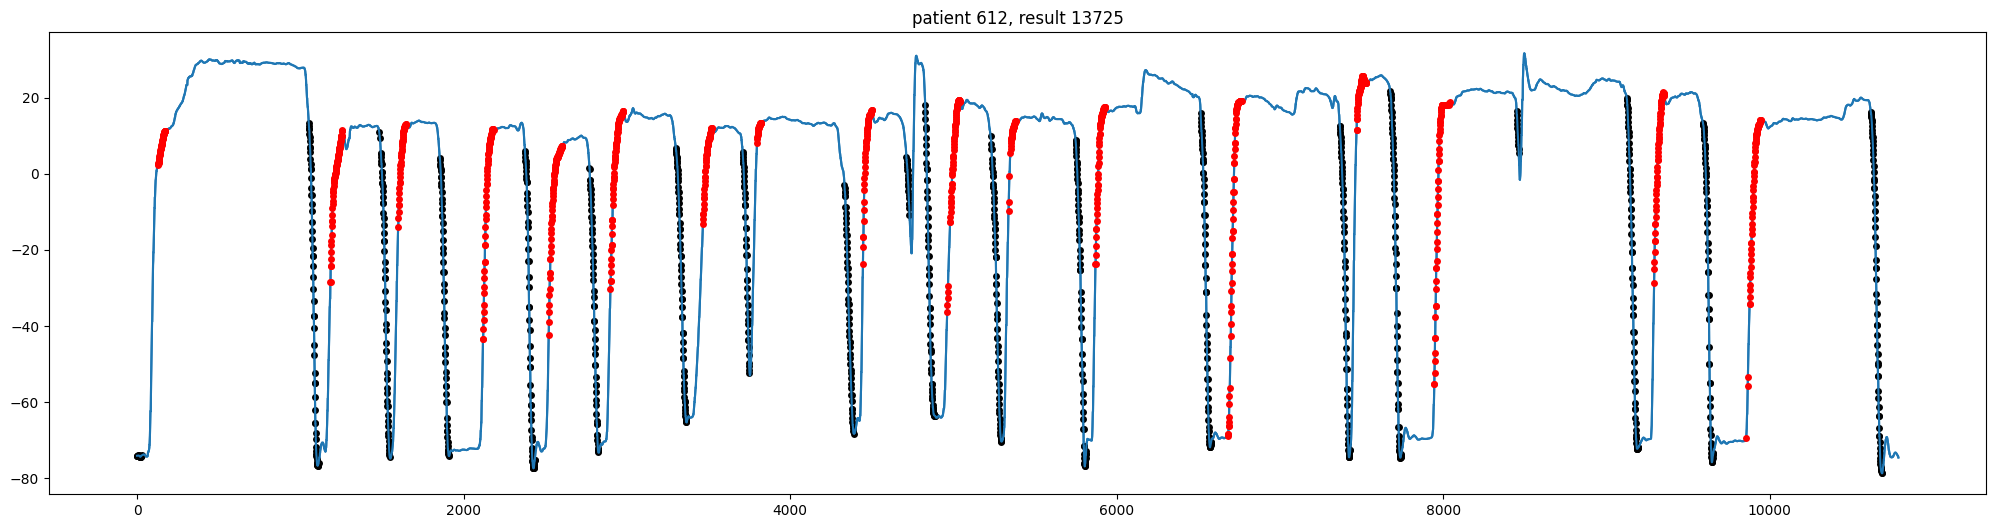

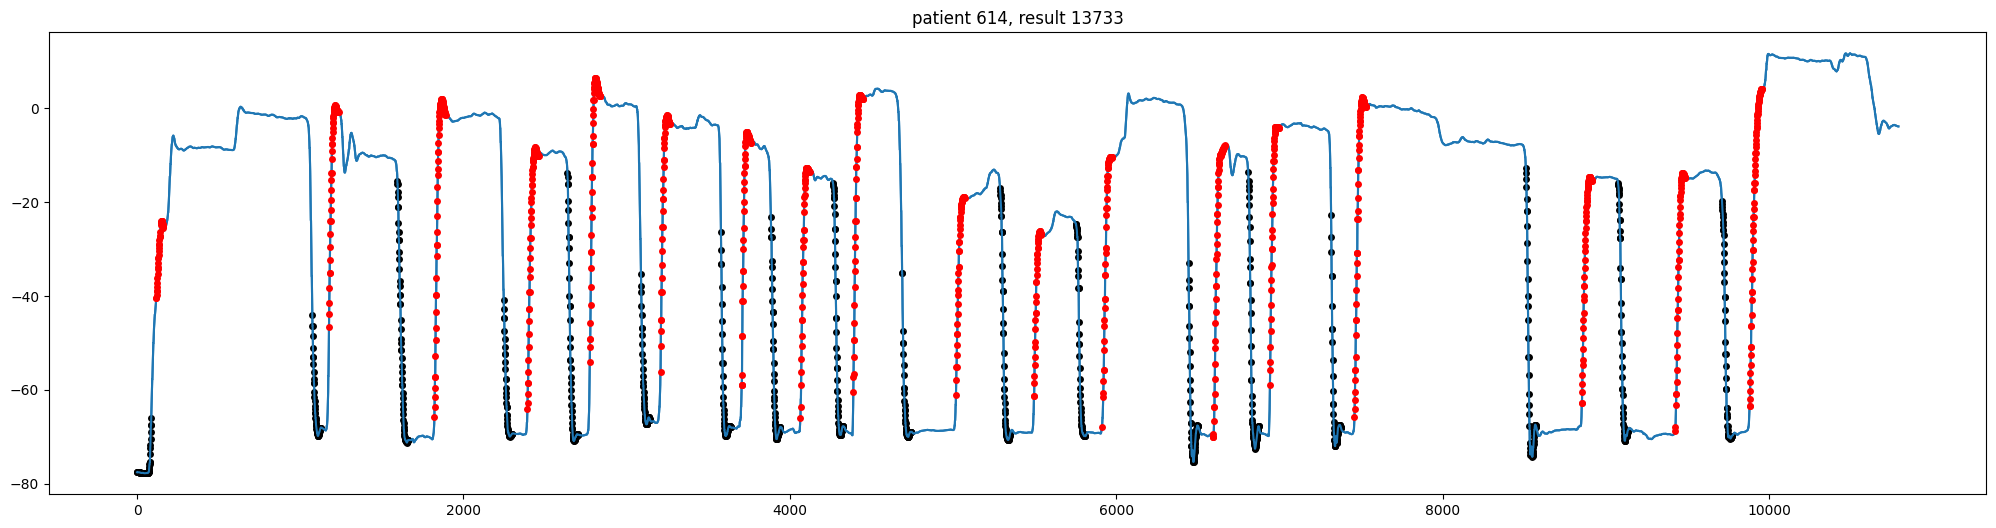

<Figure size 640x480 with 0 Axes>

In [317]:
for result_id in X_ex7_test_preds['game_result_id'].unique():
    plot_mark_ranges_preds(df_preds=X_ex7_test_preds, result_id=result_id, key='preds')


## Feature importance

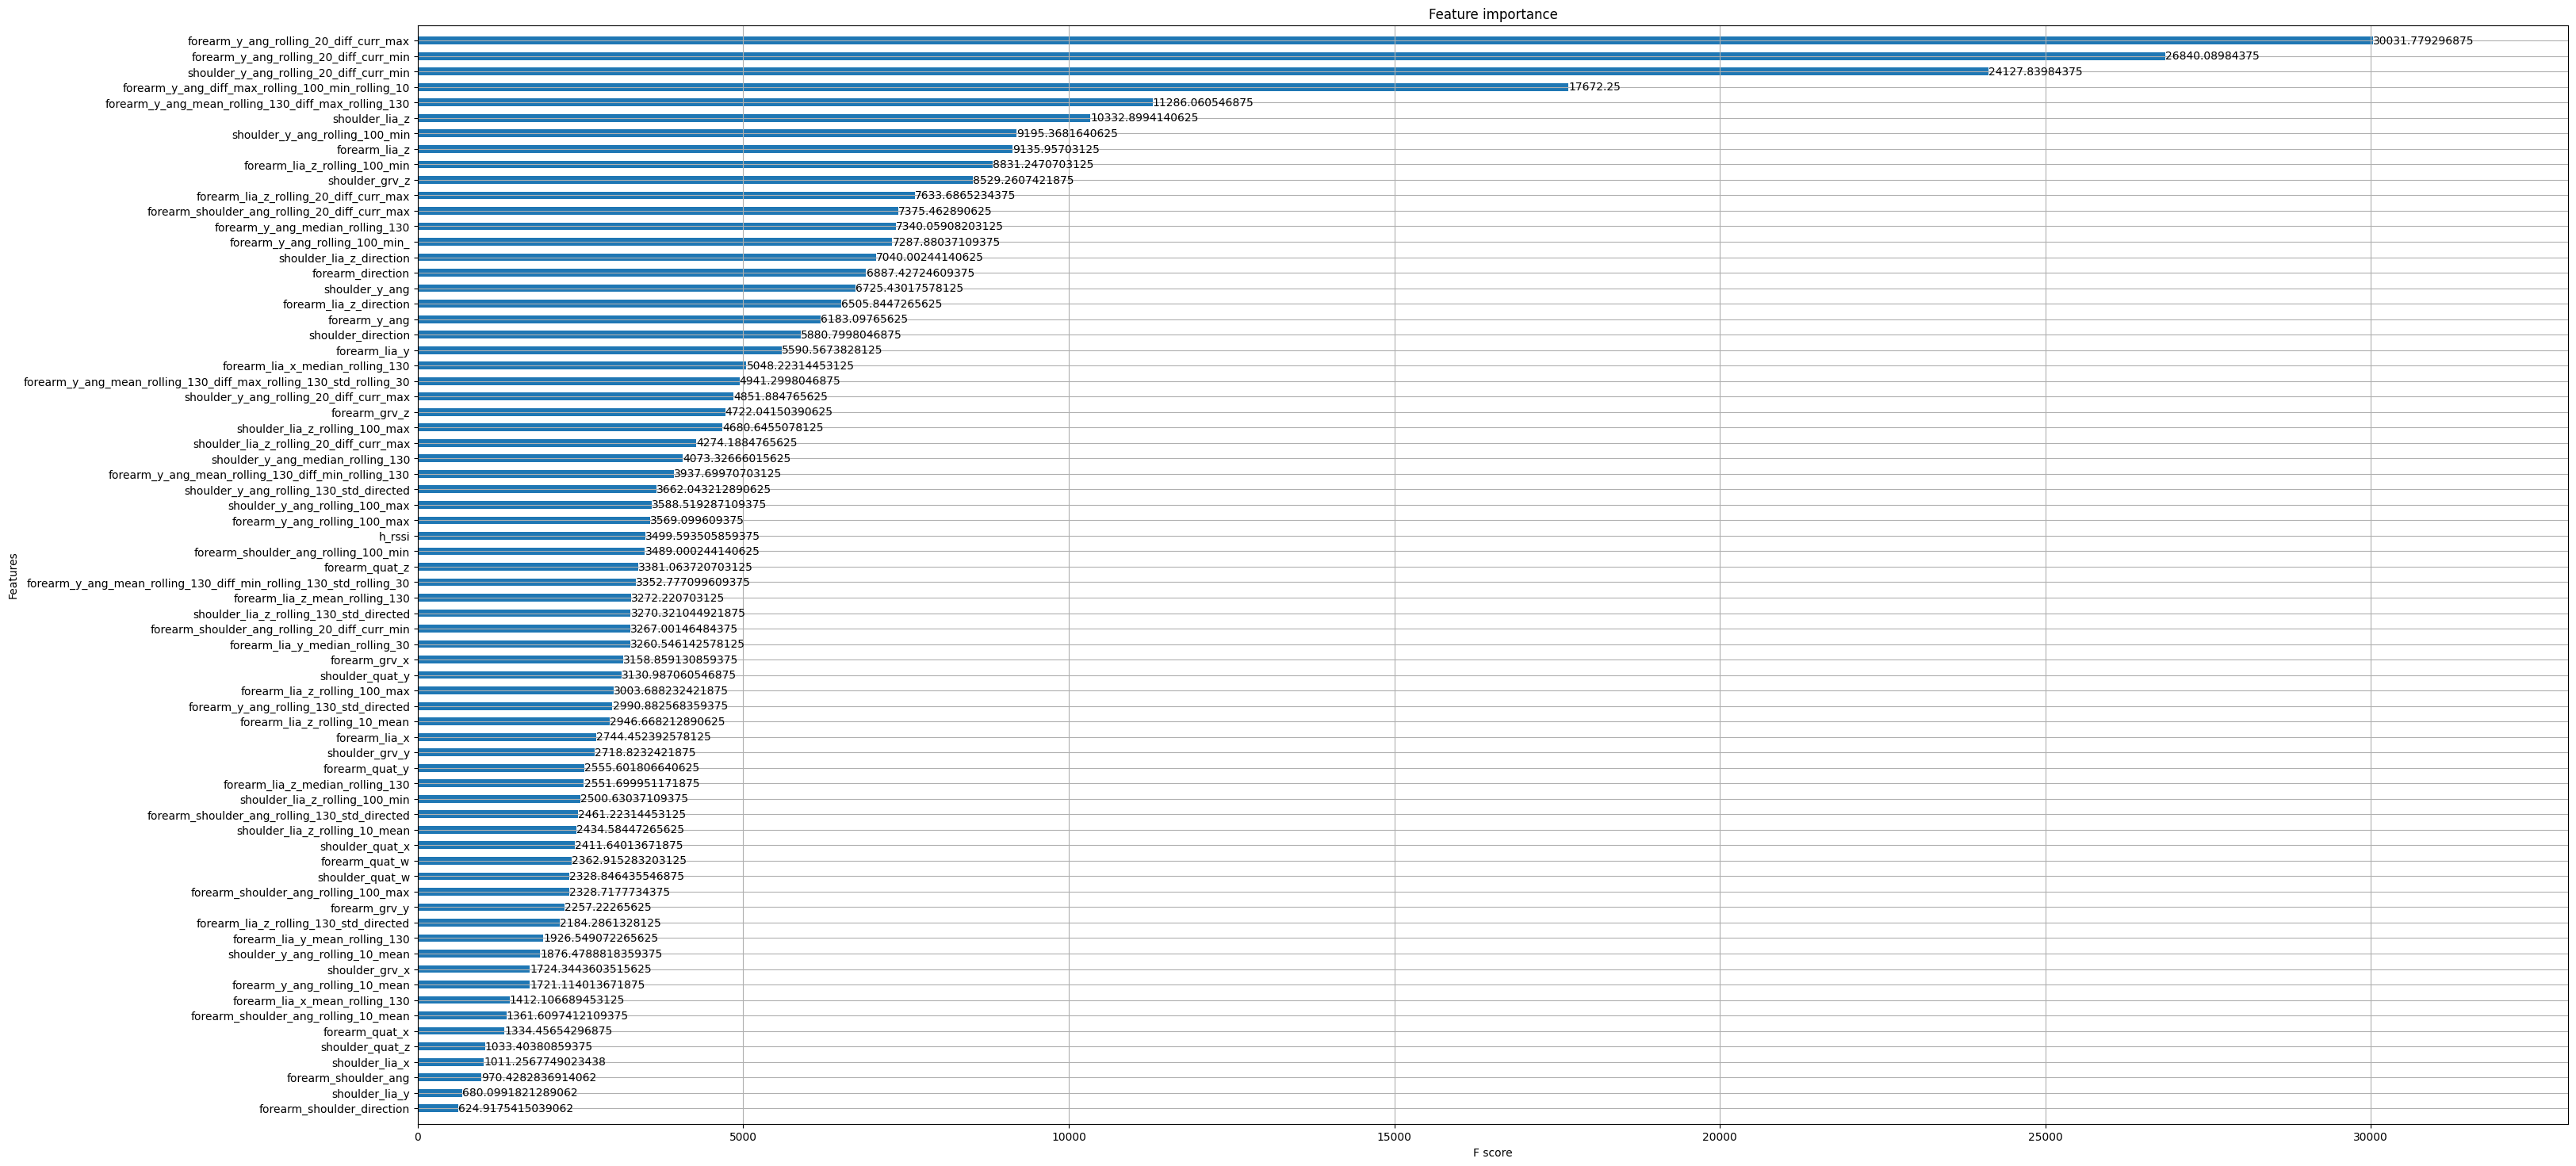

In [143]:
from xgboost import plot_importance

# sorted(impts_model.feature_importances_)
ax = plot_importance(ex7_final_xgboost_model, height=0.5, importance_type='cover')
fig = ax.figure
fig.set_size_inches(35, 18)
pyplot.show()


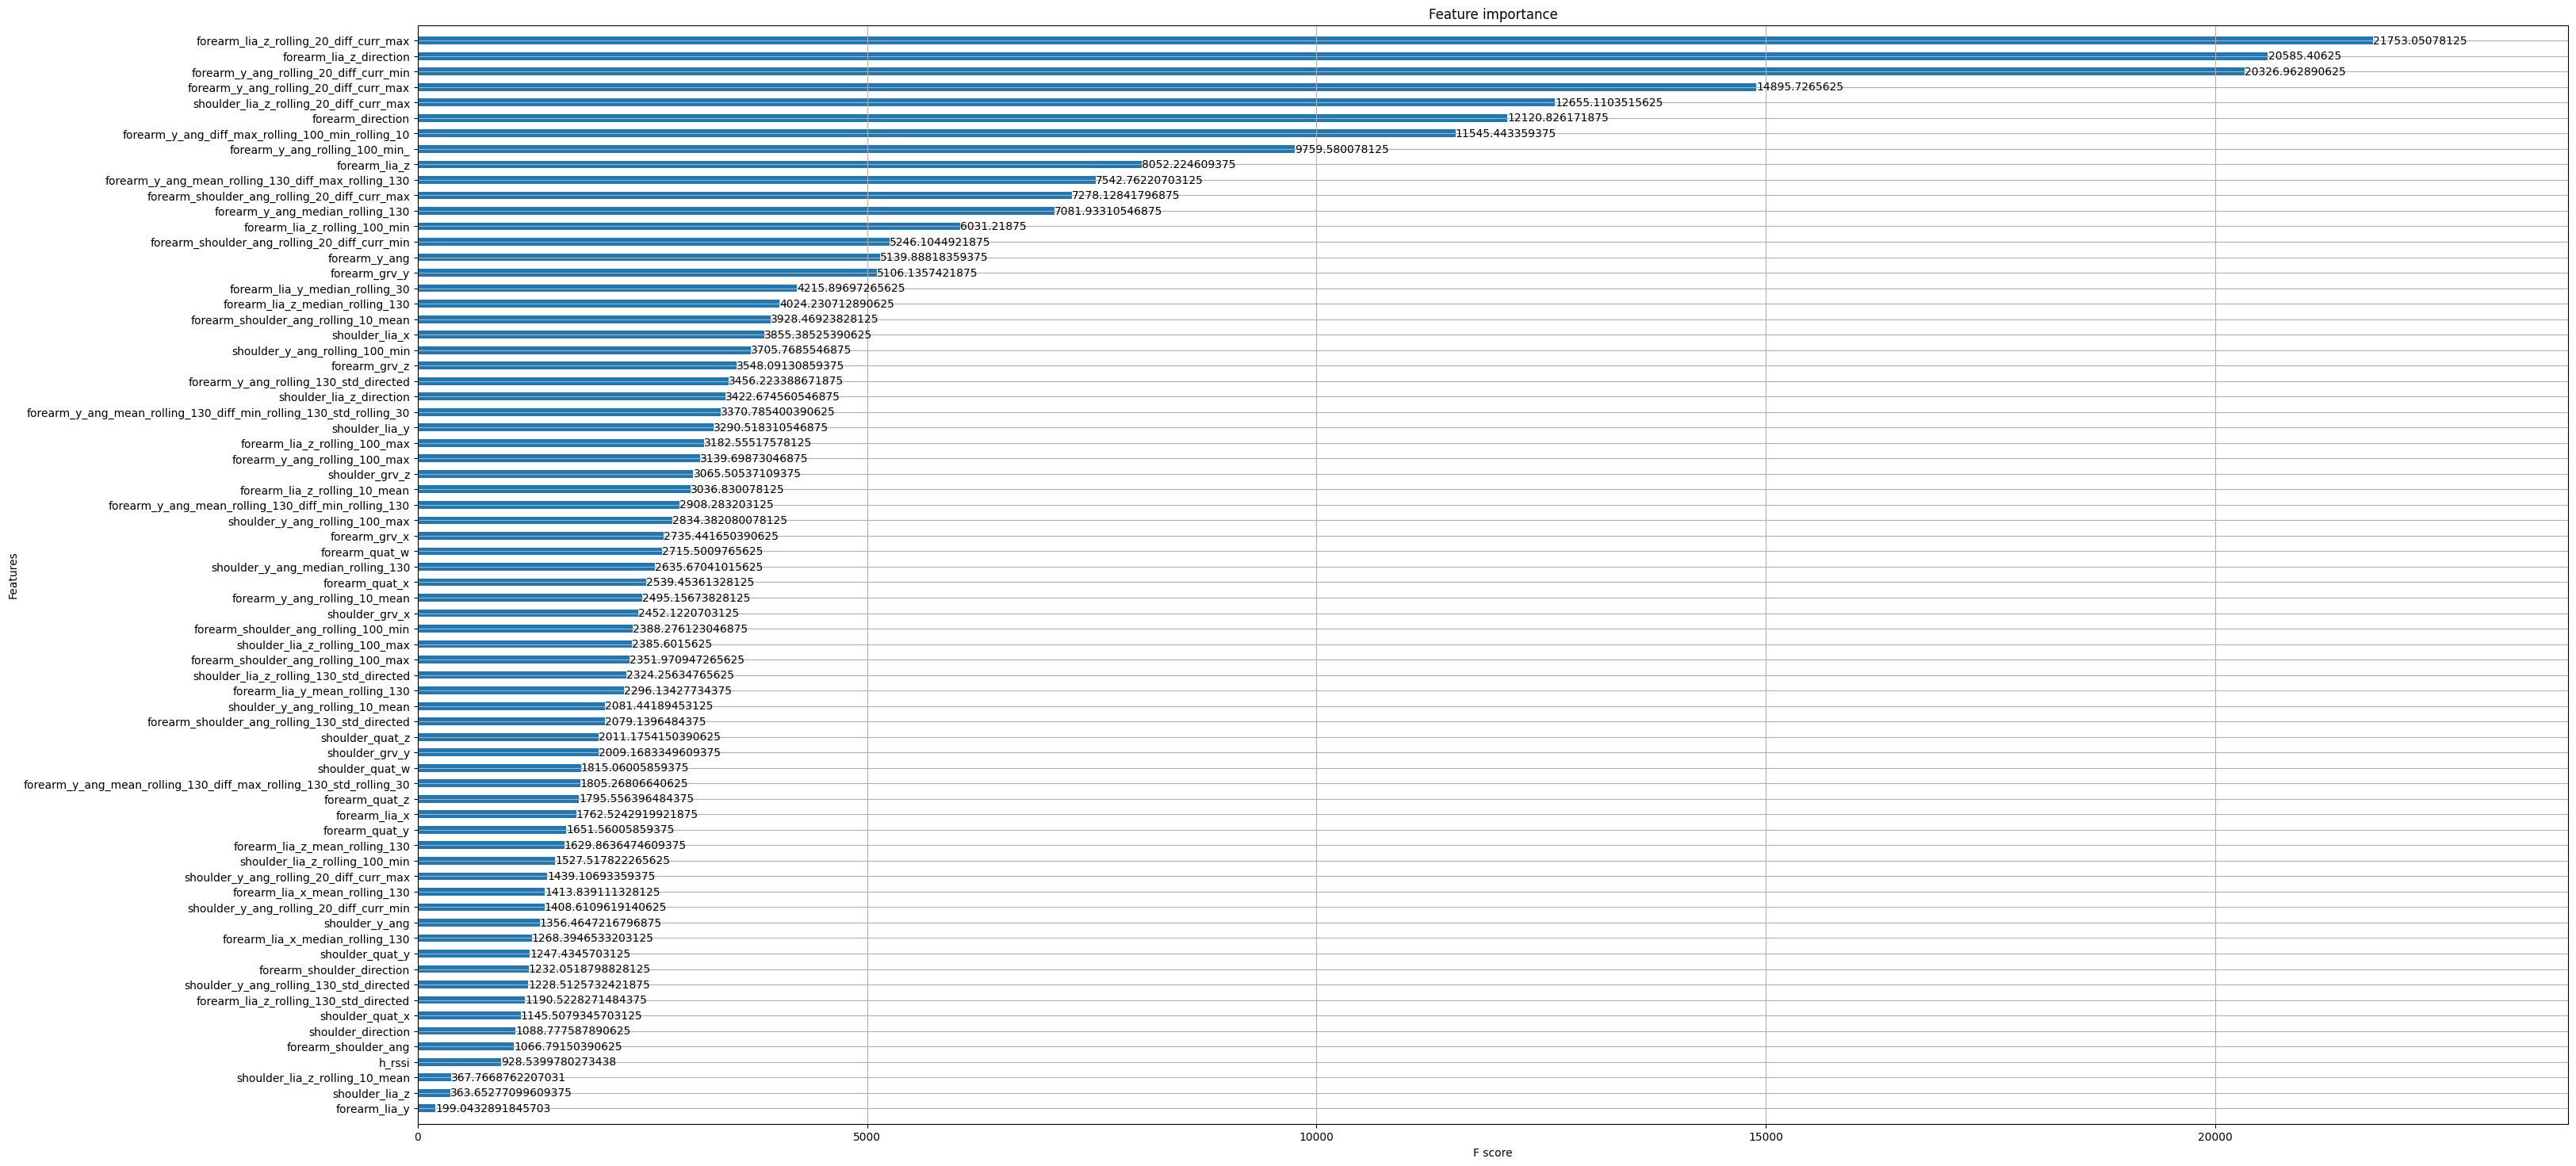

In [144]:
ax = plot_importance(ex8_final_xgboost_model, height=0.5, importance_type='cover')
fig = ax.figure
fig.set_size_inches(35, 18)
pyplot.show()


In [288]:
X_ex7 = df_ex7.loc[:, X_columns_EX7]
y_ex7 = df_ex7.loc[:, 'position_type_window']

X_ex7_train = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[:61]), X_columns_EX7]
y_ex7_train = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[:61]), 'position_type_window']

X_ex7_test = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), X_columns_EX7]
y_ex7_test = df_ex7.loc[df_ex7['game_result_id'].isin(EX7_GAME_RESULT_IDS[61:-1]), 'position_type_window']

In [293]:
X_ex8 = df_ex8.loc[:, X_columns_EX8]
y_ex8 = df_ex8.loc[:, 'position_type_window']

X_ex8_train = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[:47]), X_columns_EX8]
y_ex8_train = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[:47]), 'position_type_window']

X_ex8_test = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[47:-1]), X_columns_EX8]
y_ex8_test = df_ex8.loc[df_ex8['game_result_id'].isin(EX8_GAME_RESULT_IDS[47:-1]), 'position_type_window']

In [292]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex7_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
result = cross_val_score(
    ex7_cv_xgboost_model,
    X_ex7,
    y_ex7,
    cv=gkfold,
    groups=df_ex7['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))
# Before filtering features accuracy: 88.41% (0.94%)

Accuracy: 88.41% (0.86%)


In [294]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
ex8_cv_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12)
ex8_result = cross_val_score(
    ex8_cv_xgboost_model,
    X_ex8,
    y_ex8,
    cv=gkfold,
    groups=df_ex8['game_result_id'],
    n_jobs=N_SPLITS
)
print("Accuracy: %.2f%% (%.2f%%)" % (ex8_result.mean()*100, ex8_result.std()*100))
# Before filtering features accuracy: 87.41% (1.19%%)

Accuracy: 87.56% (0.82%)


## XGBoost inference

### General model

In [296]:
X_train_infr = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:110]), X_columns]
y_train_infr = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:110]), 'position_type_window']

X_test_infr = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[110:-1]), X_columns]
y_test_infr = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[110:-1]), 'position_type_window']

X_train_infr.columns = ['f' + str(i) for i in range(0, len(X_train.columns))]
X_test_infr.columns = ['f' + str(i) for i in range(0, len(X_test.columns))]


ValueError: Length mismatch: Expected axis has 78 elements, new values have 81 elements

In [122]:
infr_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=16)
infr_xgboost_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=16, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [123]:
from sklearn.metrics import accuracy_score

preds = infr_xgboost_model.predict(X_test)
print(accuracy_score(y_test, preds))


0.9215304798962386


In [127]:
import onnxmltools
from onnxconverter_common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost

initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onx = convert_xgboost(model, initial_types=initial_type)
with open("./onnx/xgboost_v2_all_features.onnx", "wb") as f:
    f.write(onx.SerializeToString())


In [128]:
import numpy
import onnxruntime

sess = onnxruntime.InferenceSession("./onnx/xgboost_v2_all_features.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
print(input_name, label_name)
pred_onx = sess.run(None, {input_name: X_test.reset_index(drop=True).astype(numpy.float32).to_numpy()})[0]
print(accuracy_score(y_test, pred_onx))


float_input label
0.9215304798962386


### Splitted ex7 model

In [129]:
X_ex7_train_infr = X_ex7_train.copy(deep=True)
X_ex7_test_infr = X_ex7_test.copy(deep=True)

X_ex7_train_infr.columns = ['f' + str(i) for i in range(0, len(X_ex7_train.columns))]
X_ex7_test_infr.columns = ['f' + str(i) for i in range(0, len(X_ex7_test.columns))]


In [131]:
infr_ex7_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=16, colsample_bytree = 0.67, subsample = 0.7)
infr_ex7_xgboost_model.fit(X_ex7_train_infr, y_ex7_train)


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.67, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=16, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [132]:
from sklearn.metrics import accuracy_score

preds = infr_ex7_xgboost_model.predict(X_ex7_test_infr)
print(accuracy_score(y_ex7_test, preds))
# Before filtering features accuracy: 0.923272946300329
# Before add colsample and subsample: 0.924014270490664

0.9264699068711486


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

### Overfitting for ex7 model

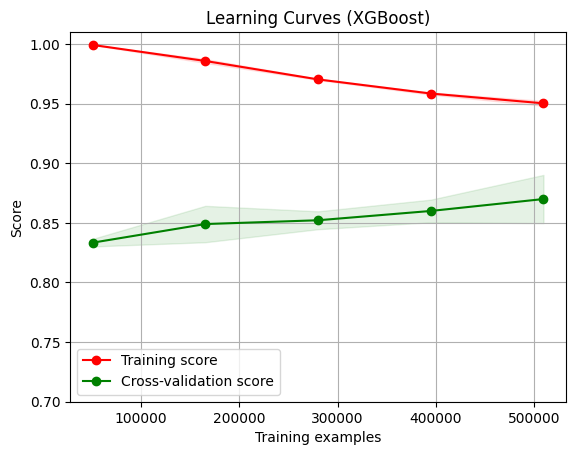

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Используйте вашу модель и данные
title = "Learning Curves (XGBoost)"
cv = 5  # Количество фолдов для кросс-валидации

plot_learning_curve(infr_ex7_xgboost_model, title, X_ex7, y_ex7, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

### Underfitting & Overfitting for ex7 model

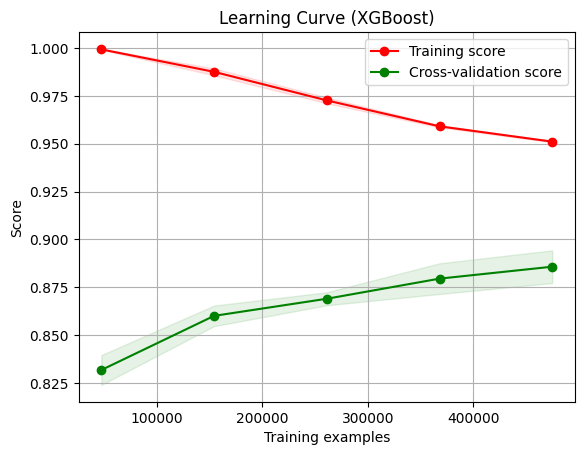

In [142]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X_ex7, y_ex7, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), groups=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_ex7, y_ex7, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, groups=groups)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12, colsample_bytree = 0.67, subsample = 0.7)
title = "Learning Curve (XGBoost)"
plot_learning_curve(model, title, X_ex7, y_ex7, cv=gkfold, n_jobs=N_SPLITS, groups=df_ex7['game_result_id'])

plt.show()

In [323]:
from onnxconverter_common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost

initial_type = [('float_input', FloatTensorType([None, X_ex7_train_infr.shape[1]]))]
onx = convert_xgboost(infr_ex7_xgboost_model, initial_types=initial_type)
with open("./onnx/xgboost_v4_ex7_all_features.onnx", "wb") as f:
    f.write(onx.SerializeToString())


In [324]:
import numpy
import onnxruntime

sess = onnxruntime.InferenceSession(
    "./onnx/xgboost_v3_ex7_all_features.onnx",
    providers=["CPUExecutionProvider"]
)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
print(input_name, label_name)
pred_onx = sess.run(None, {input_name: X_ex7_test_infr.reset_index(drop=True).astype(numpy.float32).to_numpy()})[0]
print(accuracy_score(y_ex7_test, pred_onx))


float_input label
0.923272946300329


### Splitted ex8 model

In [133]:
X_ex8_train_infr = X_ex8_train.copy(deep=True)
X_ex8_test_infr = X_ex8_test.copy(deep=True)

X_ex8_train_infr.columns = ['f' + str(i) for i in range(0, len(X_ex8_train.columns))]
X_ex8_test_infr.columns = ['f' + str(i) for i in range(0, len(X_ex8_test.columns))]


In [135]:
infr_ex8_xgboost_model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=16, colsample_bytree = 0.5, subsample = 0.65)
infr_ex8_xgboost_model.fit(X_ex8_train_infr, y_ex8_train)


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=16, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [136]:
from sklearn.metrics import accuracy_score

preds = infr_ex8_xgboost_model.predict(X_ex8_test_infr)
print(accuracy_score(y_ex8_test, preds))
# Before filtering features accuracy: 0.9105058365758755
# Before add colsample and subsample: 0.9143042430980174

0.921159903650176


C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\ITMEDIA_PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_catego

### Overfitting for ex8 model

### Underfitting & Overfitting for ex8 model

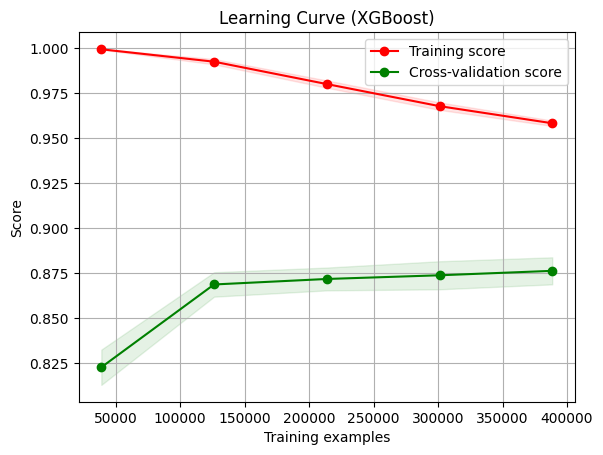

In [143]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X_ex8, y_ex8, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), groups=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_ex8, y_ex8, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, groups=groups)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=12, colsample_bytree = 0.5, subsample = 0.65)
title = "Learning Curve (XGBoost)"
plot_learning_curve(model, title, X_ex8, y_ex8, cv=gkfold, n_jobs=N_SPLITS, groups=df_ex8['game_result_id'])

plt.show()

In [353]:
from onnxconverter_common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost

initial_type = [('float_input', FloatTensorType([None, X_ex8_train_infr.shape[1]]))]
onx = convert_xgboost(infr_ex8_xgboost_model, initial_types=initial_type)
with open("./onnx/xgboost_v4_ex8_all_features.onnx", "wb") as f:
    f.write(onx.SerializeToString())


In [354]:
import numpy
import onnxruntime

sess = onnxruntime.InferenceSession(
    "./onnx/xgboost_v4_ex8_all_features.onnx",
    providers=["CPUExecutionProvider"]
)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
print(input_name, label_name)
pred_onx = sess.run(None, {input_name: X_ex8_test_infr.reset_index(drop=True).astype(numpy.float32).to_numpy()})[0]
print(accuracy_score(y_ex8_test, pred_onx))


float_input label
0.9105058365758755
